In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import site
site.addsitedir('../../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img_dir = "../../../Data/TrainingData/AR-UNet/BAMC-PTX*Sliding-Annotations-Linear/"

all_images = sorted(glob(os.path.join(img_dir, '*_?????.mha')))
all_labels = sorted(glob(os.path.join(img_dir, '*twoclass.mha')))

num_images = len(all_images)
num_labels = len(all_labels)
print(num_images, num_labels)

val_images = []
val_labels = []
train_images = []
train_labels = []
for i in range(num_images):
    if i%8 == 0 or (i%2 == 0 and i<num_images/2):
        val_images.append(all_images[i])
        val_labels.append(all_labels[i])
    else:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])

print(len(train_images), len(val_images))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

58 58
39 19


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keys=['image', 'label'],
            keep_size=True,
            mode=['trilinear', 'nearest']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        Resized(keys=["image", "label"],
            spatial_size=[320,320,60],
            mode=['trilinear', 'nearest']),
        ARGUS_RandSpatialCropSlicesd(num_slices=48,
            axis=2,
            center_slice=30,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([1, 1, 320, 320, 48])
torch.Size([320, 320, 48])
image shape: torch.Size([320, 320, 48]), label shape: torch.Size([320, 320, 48])


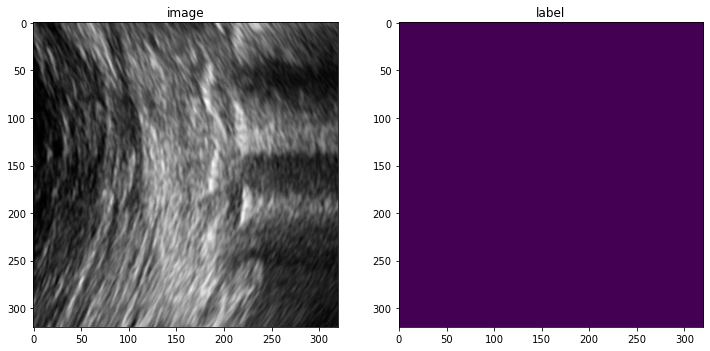

In [4]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 2], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 2])
plt.show()

In [5]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
#train_ds = Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)


val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
    
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4)

Loading dataset: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
#torch.cuda.empty_cache()

device = torch.device("cuda:0")

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [7]:
max_epochs = 2000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=2)])

root_dir = "."

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (320, 320, 48)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "BAMC_PTX_3DUNet-2Class.best_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/2000
1/9, train_loss: 0.5996
2/9, train_loss: 0.6036
3/9, train_loss: 0.5765
4/9, train_loss: 0.6144
5/9, train_loss: 0.6141
6/9, train_loss: 0.5804
7/9, train_loss: 0.6005
8/9, train_loss: 0.6047
9/9, train_loss: 0.5607
10/9, train_loss: 0.5515
epoch 1 average loss: 0.5906
----------
epoch 2/2000
1/9, train_loss: 0.5679
2/9, train_loss: 0.5069
3/9, train_loss: 0.5590
4/9, train_loss: 0.6033
5/9, train_loss: 0.5630
6/9, train_loss: 0.5950
7/9, train_loss: 0.5552
8/9, train_loss: 0.6489
9/9, train_loss: 0.6189
10/9, train_loss: 0.5794
epoch 2 average loss: 0.5798
saved new best metric model
current epoch: 2 current mean dice: 0.3088
best mean dice: 0.3088 at epoch: 2
----------
epoch 3/2000
1/9, train_loss: 0.5490
2/9, train_loss: 0.6144
3/9, train_loss: 0.5962
4/9, train_loss: 0.6129
5/9, train_loss: 0.5801
6/9, train_loss: 0.5801
7/9, train_loss: 0.5098
8/9, train_loss: 0.5560
9/9, train_loss: 0.5382
10/9, train_loss: 0.5662
epoch 3 average loss: 0.5703
----------
e

1/9, train_loss: 0.4606
2/9, train_loss: 0.4845
3/9, train_loss: 0.4081
4/9, train_loss: 0.3859
5/9, train_loss: 0.4816
6/9, train_loss: 0.4011
7/9, train_loss: 0.2882
8/9, train_loss: 0.5430
9/9, train_loss: 0.4655
10/9, train_loss: 0.4912
epoch 25 average loss: 0.4410
----------
epoch 26/2000
1/9, train_loss: 0.4896
2/9, train_loss: 0.4057
3/9, train_loss: 0.3075
4/9, train_loss: 0.4145
5/9, train_loss: 0.5692
6/9, train_loss: 0.5522
7/9, train_loss: 0.3570
8/9, train_loss: 0.4788
9/9, train_loss: 0.3874
10/9, train_loss: 0.5048
epoch 26 average loss: 0.4466
saved new best metric model
current epoch: 26 current mean dice: 0.5393
best mean dice: 0.5393 at epoch: 26
----------
epoch 27/2000
1/9, train_loss: 0.5319
2/9, train_loss: 0.3825
3/9, train_loss: 0.4011
4/9, train_loss: 0.3511
5/9, train_loss: 0.3793
6/9, train_loss: 0.4978
7/9, train_loss: 0.4832
8/9, train_loss: 0.5499
9/9, train_loss: 0.3015
10/9, train_loss: 0.4579
epoch 27 average loss: 0.4336
----------
epoch 28/2000
1/9,

5/9, train_loss: 0.3888
6/9, train_loss: 0.4337
7/9, train_loss: 0.3170
8/9, train_loss: 0.4726
9/9, train_loss: 0.3494
10/9, train_loss: 0.3166
epoch 49 average loss: 0.3809
----------
epoch 50/2000
1/9, train_loss: 0.5211
2/9, train_loss: 0.3882
3/9, train_loss: 0.2620
4/9, train_loss: 0.4875
5/9, train_loss: 0.4463
6/9, train_loss: 0.2757
7/9, train_loss: 0.4608
8/9, train_loss: 0.3316
9/9, train_loss: 0.2645
10/9, train_loss: 0.3711
epoch 50 average loss: 0.3809
current epoch: 50 current mean dice: 0.5365
best mean dice: 0.5418 at epoch: 34
----------
epoch 51/2000
1/9, train_loss: 0.3593
2/9, train_loss: 0.4372
3/9, train_loss: 0.4146
4/9, train_loss: 0.2408
5/9, train_loss: 0.4072
6/9, train_loss: 0.4397
7/9, train_loss: 0.5166
8/9, train_loss: 0.3800
9/9, train_loss: 0.4098
10/9, train_loss: 0.2529
epoch 51 average loss: 0.3858
----------
epoch 52/2000
1/9, train_loss: 0.2819
2/9, train_loss: 0.3814
3/9, train_loss: 0.3573
4/9, train_loss: 0.3164
5/9, train_loss: 0.3703
6/9, tra

6/9, train_loss: 0.4710
7/9, train_loss: 0.4170
8/9, train_loss: 0.4329
9/9, train_loss: 0.3934
10/9, train_loss: 0.2458
epoch 73 average loss: 0.3546
----------
epoch 74/2000
1/9, train_loss: 0.3728
2/9, train_loss: 0.3041
3/9, train_loss: 0.3739
4/9, train_loss: 0.3249
5/9, train_loss: 0.3370
6/9, train_loss: 0.2066
7/9, train_loss: 0.3867
8/9, train_loss: 0.3999
9/9, train_loss: 0.5131
10/9, train_loss: 0.3809
epoch 74 average loss: 0.3600
current epoch: 74 current mean dice: 0.5151
best mean dice: 0.5625 at epoch: 72
----------
epoch 75/2000
1/9, train_loss: 0.3158
2/9, train_loss: 0.3780
3/9, train_loss: 0.3018
4/9, train_loss: 0.4040
5/9, train_loss: 0.3371
6/9, train_loss: 0.2984
7/9, train_loss: 0.3892
8/9, train_loss: 0.4820
9/9, train_loss: 0.2680
10/9, train_loss: 0.4437
epoch 75 average loss: 0.3618
----------
epoch 76/2000
1/9, train_loss: 0.3586
2/9, train_loss: 0.2799
3/9, train_loss: 0.3113
4/9, train_loss: 0.4007
5/9, train_loss: 0.2787
6/9, train_loss: 0.2607
7/9, tra

1/9, train_loss: 0.2999
2/9, train_loss: 0.2561
3/9, train_loss: 0.4015
4/9, train_loss: 0.3746
5/9, train_loss: 0.3150
6/9, train_loss: 0.2818
7/9, train_loss: 0.3938
8/9, train_loss: 0.4569
9/9, train_loss: 0.3628
10/9, train_loss: 0.2253
epoch 98 average loss: 0.3368
current epoch: 98 current mean dice: 0.5309
best mean dice: 0.5625 at epoch: 72
----------
epoch 99/2000
1/9, train_loss: 0.4130
2/9, train_loss: 0.3505
3/9, train_loss: 0.2282
4/9, train_loss: 0.3775
5/9, train_loss: 0.2681
6/9, train_loss: 0.3755
7/9, train_loss: 0.3138
8/9, train_loss: 0.3449
9/9, train_loss: 0.3559
10/9, train_loss: 0.3173
epoch 99 average loss: 0.3345
----------
epoch 100/2000
1/9, train_loss: 0.3612
2/9, train_loss: 0.3662
3/9, train_loss: 0.2566
4/9, train_loss: 0.3026
5/9, train_loss: 0.4697
6/9, train_loss: 0.3831
7/9, train_loss: 0.1913
8/9, train_loss: 0.4740
9/9, train_loss: 0.2030
10/9, train_loss: 0.3193
epoch 100 average loss: 0.3327
current epoch: 100 current mean dice: 0.5411
best mean 

5/9, train_loss: 0.2963
6/9, train_loss: 0.2806
7/9, train_loss: 0.4235
8/9, train_loss: 0.2623
9/9, train_loss: 0.2920
10/9, train_loss: 0.4232
epoch 122 average loss: 0.3337
current epoch: 122 current mean dice: 0.5340
best mean dice: 0.5625 at epoch: 72
----------
epoch 123/2000
1/9, train_loss: 0.2730
2/9, train_loss: 0.3316
3/9, train_loss: 0.2653
4/9, train_loss: 0.3394
5/9, train_loss: 0.4486
6/9, train_loss: 0.3825
7/9, train_loss: 0.2033
8/9, train_loss: 0.3578
9/9, train_loss: 0.3674
10/9, train_loss: 0.2691
epoch 123 average loss: 0.3238
----------
epoch 124/2000
1/9, train_loss: 0.3599
2/9, train_loss: 0.3059
3/9, train_loss: 0.1818
4/9, train_loss: 0.2465
5/9, train_loss: 0.2794
6/9, train_loss: 0.3690
7/9, train_loss: 0.4727
8/9, train_loss: 0.4965
9/9, train_loss: 0.3394
10/9, train_loss: 0.2715
epoch 124 average loss: 0.3323
current epoch: 124 current mean dice: 0.5430
best mean dice: 0.5625 at epoch: 72
----------
epoch 125/2000
1/9, train_loss: 0.2927
2/9, train_loss:

8/9, train_loss: 0.2882
9/9, train_loss: 0.2000
10/9, train_loss: 0.3970
epoch 146 average loss: 0.3289
current epoch: 146 current mean dice: 0.5523
best mean dice: 0.5625 at epoch: 72
----------
epoch 147/2000
1/9, train_loss: 0.2707
2/9, train_loss: 0.2894
3/9, train_loss: 0.3395
4/9, train_loss: 0.2976
5/9, train_loss: 0.3671
6/9, train_loss: 0.4370
7/9, train_loss: 0.3715
8/9, train_loss: 0.2333
9/9, train_loss: 0.2562
10/9, train_loss: 0.2908
epoch 147 average loss: 0.3153
----------
epoch 148/2000
1/9, train_loss: 0.3106
2/9, train_loss: 0.3507
3/9, train_loss: 0.3803
4/9, train_loss: 0.2910
5/9, train_loss: 0.4493
6/9, train_loss: 0.3776
7/9, train_loss: 0.2533
8/9, train_loss: 0.3527
9/9, train_loss: 0.1652
10/9, train_loss: 0.2918
epoch 148 average loss: 0.3222
current epoch: 148 current mean dice: 0.5214
best mean dice: 0.5625 at epoch: 72
----------
epoch 149/2000
1/9, train_loss: 0.2788
2/9, train_loss: 0.3627
3/9, train_loss: 0.4719
4/9, train_loss: 0.2748
5/9, train_loss:

current epoch: 170 current mean dice: 0.5190
best mean dice: 0.5625 at epoch: 72
----------
epoch 171/2000
1/9, train_loss: 0.2497
2/9, train_loss: 0.2710
3/9, train_loss: 0.4134
4/9, train_loss: 0.3238
5/9, train_loss: 0.2902
6/9, train_loss: 0.2093
7/9, train_loss: 0.4664
8/9, train_loss: 0.3693
9/9, train_loss: 0.3762
10/9, train_loss: 0.1952
epoch 171 average loss: 0.3164
----------
epoch 172/2000
1/9, train_loss: 0.3725
2/9, train_loss: 0.2842
3/9, train_loss: 0.2839
4/9, train_loss: 0.3224
5/9, train_loss: 0.1621
6/9, train_loss: 0.3380
7/9, train_loss: 0.2748
8/9, train_loss: 0.3444
9/9, train_loss: 0.2843
10/9, train_loss: 0.5494
epoch 172 average loss: 0.3216
current epoch: 172 current mean dice: 0.5033
best mean dice: 0.5625 at epoch: 72
----------
epoch 173/2000
1/9, train_loss: 0.4394
2/9, train_loss: 0.3582
3/9, train_loss: 0.4311
4/9, train_loss: 0.3248
5/9, train_loss: 0.3563
6/9, train_loss: 0.2584
7/9, train_loss: 0.2525
8/9, train_loss: 0.1693
9/9, train_loss: 0.2430


1/9, train_loss: 0.1799
2/9, train_loss: 0.1600
3/9, train_loss: 0.3468
4/9, train_loss: 0.3715
5/9, train_loss: 0.3575
6/9, train_loss: 0.3936
7/9, train_loss: 0.3317
8/9, train_loss: 0.3808
9/9, train_loss: 0.2335
10/9, train_loss: 0.3808
epoch 195 average loss: 0.3136
----------
epoch 196/2000
1/9, train_loss: 0.4637
2/9, train_loss: 0.3563
3/9, train_loss: 0.2561
4/9, train_loss: 0.1888
5/9, train_loss: 0.2591
6/9, train_loss: 0.2543
7/9, train_loss: 0.1656
8/9, train_loss: 0.3541
9/9, train_loss: 0.4789
10/9, train_loss: 0.4077
epoch 196 average loss: 0.3185
current epoch: 196 current mean dice: 0.5576
best mean dice: 0.5741 at epoch: 174
----------
epoch 197/2000
1/9, train_loss: 0.2555
2/9, train_loss: 0.1867
3/9, train_loss: 0.3573
4/9, train_loss: 0.2832
5/9, train_loss: 0.3651
6/9, train_loss: 0.2514
7/9, train_loss: 0.3329
8/9, train_loss: 0.4299
9/9, train_loss: 0.3354
10/9, train_loss: 0.2802
epoch 197 average loss: 0.3078
----------
epoch 198/2000
1/9, train_loss: 0.3584


3/9, train_loss: 0.3216
4/9, train_loss: 0.3680
5/9, train_loss: 0.3428
6/9, train_loss: 0.3380
7/9, train_loss: 0.3554
8/9, train_loss: 0.2653
9/9, train_loss: 0.2261
10/9, train_loss: 0.2103
epoch 219 average loss: 0.3099
----------
epoch 220/2000
1/9, train_loss: 0.2888
2/9, train_loss: 0.2570
3/9, train_loss: 0.2384
4/9, train_loss: 0.2826
5/9, train_loss: 0.3469
6/9, train_loss: 0.4933
7/9, train_loss: 0.2630
8/9, train_loss: 0.3259
9/9, train_loss: 0.3320
10/9, train_loss: 0.3192
epoch 220 average loss: 0.3147
current epoch: 220 current mean dice: 0.5228
best mean dice: 0.5760 at epoch: 202
----------
epoch 221/2000
1/9, train_loss: 0.1820
2/9, train_loss: 0.2576
3/9, train_loss: 0.2694
4/9, train_loss: 0.1601
5/9, train_loss: 0.4398
6/9, train_loss: 0.4688
7/9, train_loss: 0.2695
8/9, train_loss: 0.3156
9/9, train_loss: 0.3651
10/9, train_loss: 0.4036
epoch 221 average loss: 0.3132
----------
epoch 222/2000
1/9, train_loss: 0.1581
2/9, train_loss: 0.2149
3/9, train_loss: 0.5438


6/9, train_loss: 0.2484
7/9, train_loss: 0.4469
8/9, train_loss: 0.3207
9/9, train_loss: 0.2934
10/9, train_loss: 0.2685
epoch 243 average loss: 0.2983
----------
epoch 244/2000
1/9, train_loss: 0.3322
2/9, train_loss: 0.3126
3/9, train_loss: 0.3764
4/9, train_loss: 0.1637
5/9, train_loss: 0.2590
6/9, train_loss: 0.2737
7/9, train_loss: 0.4331
8/9, train_loss: 0.3048
9/9, train_loss: 0.2873
10/9, train_loss: 0.2681
epoch 244 average loss: 0.3011
current epoch: 244 current mean dice: 0.5471
best mean dice: 0.5760 at epoch: 202
----------
epoch 245/2000
1/9, train_loss: 0.3362
2/9, train_loss: 0.4596
3/9, train_loss: 0.2481
4/9, train_loss: 0.2625
5/9, train_loss: 0.2395
6/9, train_loss: 0.2723
7/9, train_loss: 0.4246
8/9, train_loss: 0.1503
9/9, train_loss: 0.3562
10/9, train_loss: 0.2913
epoch 245 average loss: 0.3041
----------
epoch 246/2000
1/9, train_loss: 0.4512
2/9, train_loss: 0.3472
3/9, train_loss: 0.1452
4/9, train_loss: 0.3023
5/9, train_loss: 0.3347
6/9, train_loss: 0.3580


9/9, train_loss: 0.3288
10/9, train_loss: 0.2746
epoch 267 average loss: 0.3042
----------
epoch 268/2000
1/9, train_loss: 0.3577
2/9, train_loss: 0.3178
3/9, train_loss: 0.2800
4/9, train_loss: 0.3456
5/9, train_loss: 0.2297
6/9, train_loss: 0.2359
7/9, train_loss: 0.2601
8/9, train_loss: 0.1570
9/9, train_loss: 0.5458
10/9, train_loss: 0.2837
epoch 268 average loss: 0.3013
current epoch: 268 current mean dice: 0.4962
best mean dice: 0.5760 at epoch: 202
----------
epoch 269/2000
1/9, train_loss: 0.3196
2/9, train_loss: 0.4552
3/9, train_loss: 0.3366
4/9, train_loss: 0.2169
5/9, train_loss: 0.1496
6/9, train_loss: 0.1711
7/9, train_loss: 0.1837
8/9, train_loss: 0.3608
9/9, train_loss: 0.5432
10/9, train_loss: 0.3297
epoch 269 average loss: 0.3067
----------
epoch 270/2000
1/9, train_loss: 0.3463
2/9, train_loss: 0.3375
3/9, train_loss: 0.2738
4/9, train_loss: 0.3788
5/9, train_loss: 0.2621
6/9, train_loss: 0.3710
7/9, train_loss: 0.2401
8/9, train_loss: 0.2855
9/9, train_loss: 0.3023


1/9, train_loss: 0.1604
2/9, train_loss: 0.2788
3/9, train_loss: 0.4204
4/9, train_loss: 0.2808
5/9, train_loss: 0.4258
6/9, train_loss: 0.2592
7/9, train_loss: 0.3533
8/9, train_loss: 0.2429
9/9, train_loss: 0.2303
10/9, train_loss: 0.3564
epoch 292 average loss: 0.3008
current epoch: 292 current mean dice: 0.5715
best mean dice: 0.5760 at epoch: 202
----------
epoch 293/2000
1/9, train_loss: 0.2269
2/9, train_loss: 0.2581
3/9, train_loss: 0.4232
4/9, train_loss: 0.2626
5/9, train_loss: 0.2459
6/9, train_loss: 0.3575
7/9, train_loss: 0.3615
8/9, train_loss: 0.2596
9/9, train_loss: 0.3167
10/9, train_loss: 0.2658
epoch 293 average loss: 0.2978
----------
epoch 294/2000
1/9, train_loss: 0.2471
2/9, train_loss: 0.2744
3/9, train_loss: 0.3456
4/9, train_loss: 0.3097
5/9, train_loss: 0.3481
6/9, train_loss: 0.2217
7/9, train_loss: 0.3371
8/9, train_loss: 0.2491
9/9, train_loss: 0.3168
10/9, train_loss: 0.4163
epoch 294 average loss: 0.3066
current epoch: 294 current mean dice: 0.5184
best 

3/9, train_loss: 0.3252
4/9, train_loss: 0.3125
5/9, train_loss: 0.3542
6/9, train_loss: 0.1653
7/9, train_loss: 0.3494
8/9, train_loss: 0.3335
9/9, train_loss: 0.4664
10/9, train_loss: 0.2359
epoch 316 average loss: 0.2902
current epoch: 316 current mean dice: 0.5182
best mean dice: 0.5845 at epoch: 314
----------
epoch 317/2000
1/9, train_loss: 0.3656
2/9, train_loss: 0.3332
3/9, train_loss: 0.4558
4/9, train_loss: 0.3527
5/9, train_loss: 0.4238
6/9, train_loss: 0.1759
7/9, train_loss: 0.1470
8/9, train_loss: 0.2545
9/9, train_loss: 0.1995
10/9, train_loss: 0.2556
epoch 317 average loss: 0.2964
----------
epoch 318/2000
1/9, train_loss: 0.3518
2/9, train_loss: 0.4158
3/9, train_loss: 0.2529
4/9, train_loss: 0.2077
5/9, train_loss: 0.1771
6/9, train_loss: 0.3062
7/9, train_loss: 0.2218
8/9, train_loss: 0.3299
9/9, train_loss: 0.4207
10/9, train_loss: 0.2723
epoch 318 average loss: 0.2956
current epoch: 318 current mean dice: 0.5459
best mean dice: 0.5845 at epoch: 314
----------
epoch

6/9, train_loss: 0.4150
7/9, train_loss: 0.3267
8/9, train_loss: 0.2381
9/9, train_loss: 0.3049
10/9, train_loss: 0.1821
epoch 340 average loss: 0.2983
current epoch: 340 current mean dice: 0.5294
best mean dice: 0.5845 at epoch: 314
----------
epoch 341/2000
1/9, train_loss: 0.4116
2/9, train_loss: 0.2594
3/9, train_loss: 0.2192
4/9, train_loss: 0.2418
5/9, train_loss: 0.2507
6/9, train_loss: 0.2793
7/9, train_loss: 0.4083
8/9, train_loss: 0.1379
9/9, train_loss: 0.3629
10/9, train_loss: 0.4174
epoch 341 average loss: 0.2989
----------
epoch 342/2000
1/9, train_loss: 0.2790
2/9, train_loss: 0.3271
3/9, train_loss: 0.2391
4/9, train_loss: 0.2653
5/9, train_loss: 0.1566
6/9, train_loss: 0.3299
7/9, train_loss: 0.3963
8/9, train_loss: 0.3835
9/9, train_loss: 0.1854
10/9, train_loss: 0.4027
epoch 342 average loss: 0.2965
current epoch: 342 current mean dice: 0.5502
best mean dice: 0.5845 at epoch: 314
----------
epoch 343/2000
1/9, train_loss: 0.3416
2/9, train_loss: 0.3292
3/9, train_los

8/9, train_loss: 0.1776
9/9, train_loss: 0.4216
10/9, train_loss: 0.2961
epoch 364 average loss: 0.2862
current epoch: 364 current mean dice: 0.5738
best mean dice: 0.5984 at epoch: 344
----------
epoch 365/2000
1/9, train_loss: 0.3235
2/9, train_loss: 0.3276
3/9, train_loss: 0.2659
4/9, train_loss: 0.2109
5/9, train_loss: 0.2111
6/9, train_loss: 0.4107
7/9, train_loss: 0.2782
8/9, train_loss: 0.3193
9/9, train_loss: 0.3407
10/9, train_loss: 0.2156
epoch 365 average loss: 0.2904
----------
epoch 366/2000
1/9, train_loss: 0.3390
2/9, train_loss: 0.2375
3/9, train_loss: 0.2207
4/9, train_loss: 0.4602
5/9, train_loss: 0.3560
6/9, train_loss: 0.1994
7/9, train_loss: 0.3205
8/9, train_loss: 0.3150
9/9, train_loss: 0.2366
10/9, train_loss: 0.2725
epoch 366 average loss: 0.2957
current epoch: 366 current mean dice: 0.5215
best mean dice: 0.5984 at epoch: 344
----------
epoch 367/2000
1/9, train_loss: 0.2833
2/9, train_loss: 0.1237
3/9, train_loss: 0.1385
4/9, train_loss: 0.2513
5/9, train_los

current epoch: 388 current mean dice: 0.5301
best mean dice: 0.5984 at epoch: 344
----------
epoch 389/2000
1/9, train_loss: 0.2521
2/9, train_loss: 0.2341
3/9, train_loss: 0.3953
4/9, train_loss: 0.2755
5/9, train_loss: 0.4207
6/9, train_loss: 0.1520
7/9, train_loss: 0.4310
8/9, train_loss: 0.3528
9/9, train_loss: 0.2488
10/9, train_loss: 0.1917
epoch 389 average loss: 0.2954
----------
epoch 390/2000
1/9, train_loss: 0.1713
2/9, train_loss: 0.2418
3/9, train_loss: 0.4528
4/9, train_loss: 0.3442
5/9, train_loss: 0.2872
6/9, train_loss: 0.2396
7/9, train_loss: 0.1688
8/9, train_loss: 0.4198
9/9, train_loss: 0.5010
10/9, train_loss: 0.1337
epoch 390 average loss: 0.2960
current epoch: 390 current mean dice: 0.5704
best mean dice: 0.5984 at epoch: 344
----------
epoch 391/2000
1/9, train_loss: 0.2412
2/9, train_loss: 0.3273
3/9, train_loss: 0.3548
4/9, train_loss: 0.2433
5/9, train_loss: 0.1616
6/9, train_loss: 0.2144
7/9, train_loss: 0.2196
8/9, train_loss: 0.4018
9/9, train_loss: 0.429

1/9, train_loss: 0.1400
2/9, train_loss: 0.5307
3/9, train_loss: 0.5397
4/9, train_loss: 0.2743
5/9, train_loss: 0.1254
6/9, train_loss: 0.2694
7/9, train_loss: 0.2704
8/9, train_loss: 0.3386
9/9, train_loss: 0.2326
10/9, train_loss: 0.1799
epoch 413 average loss: 0.2901
----------
epoch 414/2000
1/9, train_loss: 0.2579
2/9, train_loss: 0.1970
3/9, train_loss: 0.3835
4/9, train_loss: 0.2846
5/9, train_loss: 0.2239
6/9, train_loss: 0.3468
7/9, train_loss: 0.1702
8/9, train_loss: 0.4433
9/9, train_loss: 0.1512
10/9, train_loss: 0.5424
epoch 414 average loss: 0.3001
current epoch: 414 current mean dice: 0.5536
best mean dice: 0.5984 at epoch: 344
----------
epoch 415/2000
1/9, train_loss: 0.3731
2/9, train_loss: 0.2132
3/9, train_loss: 0.2959
4/9, train_loss: 0.3246
5/9, train_loss: 0.2337
6/9, train_loss: 0.2851
7/9, train_loss: 0.2524
8/9, train_loss: 0.4062
9/9, train_loss: 0.2554
10/9, train_loss: 0.2360
epoch 415 average loss: 0.2876
----------
epoch 416/2000
1/9, train_loss: 0.2696


4/9, train_loss: 0.3669
5/9, train_loss: 0.2717
6/9, train_loss: 0.3227
7/9, train_loss: 0.3342
8/9, train_loss: 0.1912
9/9, train_loss: 0.2559
10/9, train_loss: 0.5235
epoch 437 average loss: 0.2964
----------
epoch 438/2000
1/9, train_loss: 0.3415
2/9, train_loss: 0.3440
3/9, train_loss: 0.3213
4/9, train_loss: 0.4004
5/9, train_loss: 0.4230
6/9, train_loss: 0.1188
7/9, train_loss: 0.3519
8/9, train_loss: 0.2162
9/9, train_loss: 0.1682
10/9, train_loss: 0.2076
epoch 438 average loss: 0.2893
current epoch: 438 current mean dice: 0.5272
best mean dice: 0.5984 at epoch: 344
----------
epoch 439/2000
1/9, train_loss: 0.1372
2/9, train_loss: 0.3280
3/9, train_loss: 0.1394
4/9, train_loss: 0.4202
5/9, train_loss: 0.3219
6/9, train_loss: 0.3671
7/9, train_loss: 0.2972
8/9, train_loss: 0.2081
9/9, train_loss: 0.4255
10/9, train_loss: 0.2464
epoch 439 average loss: 0.2891
----------
epoch 440/2000
1/9, train_loss: 0.3440
2/9, train_loss: 0.1303
3/9, train_loss: 0.2229
4/9, train_loss: 0.3454


7/9, train_loss: 0.3584
8/9, train_loss: 0.3076
9/9, train_loss: 0.2018
10/9, train_loss: 0.2686
epoch 461 average loss: 0.2880
----------
epoch 462/2000
1/9, train_loss: 0.4095
2/9, train_loss: 0.4247
3/9, train_loss: 0.2707
4/9, train_loss: 0.3130
5/9, train_loss: 0.1778
6/9, train_loss: 0.3488
7/9, train_loss: 0.2109
8/9, train_loss: 0.3369
9/9, train_loss: 0.1571
10/9, train_loss: 0.3058
epoch 462 average loss: 0.2955
current epoch: 462 current mean dice: 0.5916
best mean dice: 0.5984 at epoch: 344
----------
epoch 463/2000
1/9, train_loss: 0.2326
2/9, train_loss: 0.2430
3/9, train_loss: 0.3520
4/9, train_loss: 0.2644
5/9, train_loss: 0.3342
6/9, train_loss: 0.3606
7/9, train_loss: 0.2842
8/9, train_loss: 0.1093
9/9, train_loss: 0.3373
10/9, train_loss: 0.3847
epoch 463 average loss: 0.2902
----------
epoch 464/2000
1/9, train_loss: 0.2147
2/9, train_loss: 0.4485
3/9, train_loss: 0.4398
4/9, train_loss: 0.1458
5/9, train_loss: 0.1604
6/9, train_loss: 0.3933
7/9, train_loss: 0.3408


10/9, train_loss: 0.3554
epoch 485 average loss: 0.2942
----------
epoch 486/2000
1/9, train_loss: 0.2088
2/9, train_loss: 0.4470
3/9, train_loss: 0.2526
4/9, train_loss: 0.2760
5/9, train_loss: 0.3785
6/9, train_loss: 0.2546
7/9, train_loss: 0.2436
8/9, train_loss: 0.2246
9/9, train_loss: 0.2597
10/9, train_loss: 0.3795
epoch 486 average loss: 0.2925
current epoch: 486 current mean dice: 0.4934
best mean dice: 0.5984 at epoch: 344
----------
epoch 487/2000
1/9, train_loss: 0.4222
2/9, train_loss: 0.3440
3/9, train_loss: 0.1742
4/9, train_loss: 0.2318
5/9, train_loss: 0.3394
6/9, train_loss: 0.2751
7/9, train_loss: 0.4223
8/9, train_loss: 0.1647
9/9, train_loss: 0.1322
10/9, train_loss: 0.4588
epoch 487 average loss: 0.2965
----------
epoch 488/2000
1/9, train_loss: 0.3318
2/9, train_loss: 0.2840
3/9, train_loss: 0.3567
4/9, train_loss: 0.2189
5/9, train_loss: 0.3182
6/9, train_loss: 0.3265
7/9, train_loss: 0.3148
8/9, train_loss: 0.2613
9/9, train_loss: 0.2259
10/9, train_loss: 0.1683

1/9, train_loss: 0.3806
2/9, train_loss: 0.2585
3/9, train_loss: 0.2368
4/9, train_loss: 0.1403
5/9, train_loss: 0.2331
6/9, train_loss: 0.3508
7/9, train_loss: 0.4410
8/9, train_loss: 0.2956
9/9, train_loss: 0.2834
10/9, train_loss: 0.2944
epoch 510 average loss: 0.2915
current epoch: 510 current mean dice: 0.5765
best mean dice: 0.5984 at epoch: 344
----------
epoch 511/2000
1/9, train_loss: 0.2605
2/9, train_loss: 0.1661
3/9, train_loss: 0.4294
4/9, train_loss: 0.2677
5/9, train_loss: 0.3530
6/9, train_loss: 0.3268
7/9, train_loss: 0.4628
8/9, train_loss: 0.2495
9/9, train_loss: 0.2055
10/9, train_loss: 0.1832
epoch 511 average loss: 0.2904
----------
epoch 512/2000
1/9, train_loss: 0.2519
2/9, train_loss: 0.2153
3/9, train_loss: 0.3383
4/9, train_loss: 0.4018
5/9, train_loss: 0.1366
6/9, train_loss: 0.4234
7/9, train_loss: 0.3074
8/9, train_loss: 0.3479
9/9, train_loss: 0.1558
10/9, train_loss: 0.2793
epoch 512 average loss: 0.2858
current epoch: 512 current mean dice: 0.5286
best 

4/9, train_loss: 0.2393
5/9, train_loss: 0.2808
6/9, train_loss: 0.2410
7/9, train_loss: 0.3100
8/9, train_loss: 0.2414
9/9, train_loss: 0.2195
10/9, train_loss: 0.3785
epoch 534 average loss: 0.2853
current epoch: 534 current mean dice: 0.5476
best mean dice: 0.5984 at epoch: 344
----------
epoch 535/2000
1/9, train_loss: 0.1777
2/9, train_loss: 0.3098
3/9, train_loss: 0.3962
4/9, train_loss: 0.2540
5/9, train_loss: 0.5312
6/9, train_loss: 0.2026
7/9, train_loss: 0.3058
8/9, train_loss: 0.2392
9/9, train_loss: 0.1356
10/9, train_loss: 0.2733
epoch 535 average loss: 0.2825
----------
epoch 536/2000
1/9, train_loss: 0.3629
2/9, train_loss: 0.3274
3/9, train_loss: 0.2134
4/9, train_loss: 0.3103
5/9, train_loss: 0.2041
6/9, train_loss: 0.3390
7/9, train_loss: 0.1545
8/9, train_loss: 0.2833
9/9, train_loss: 0.3599
10/9, train_loss: 0.2539
epoch 536 average loss: 0.2809
current epoch: 536 current mean dice: 0.5099
best mean dice: 0.5984 at epoch: 344
----------
epoch 537/2000
1/9, train_los

7/9, train_loss: 0.1839
8/9, train_loss: 0.5397
9/9, train_loss: 0.1433
10/9, train_loss: 0.3742
epoch 558 average loss: 0.2890
current epoch: 558 current mean dice: 0.5719
best mean dice: 0.5984 at epoch: 344
----------
epoch 559/2000
1/9, train_loss: 0.4087
2/9, train_loss: 0.2827
3/9, train_loss: 0.2186
4/9, train_loss: 0.1402
5/9, train_loss: 0.3218
6/9, train_loss: 0.2346
7/9, train_loss: 0.3255
8/9, train_loss: 0.4285
9/9, train_loss: 0.2329
10/9, train_loss: 0.1374
epoch 559 average loss: 0.2731
----------
epoch 560/2000
1/9, train_loss: 0.2427
2/9, train_loss: 0.2434
3/9, train_loss: 0.3496
4/9, train_loss: 0.1996
5/9, train_loss: 0.2275
6/9, train_loss: 0.2176
7/9, train_loss: 0.4462
8/9, train_loss: 0.2794
9/9, train_loss: 0.3269
10/9, train_loss: 0.2693
epoch 560 average loss: 0.2802
current epoch: 560 current mean dice: 0.5555
best mean dice: 0.5984 at epoch: 344
----------
epoch 561/2000
1/9, train_loss: 0.2137
2/9, train_loss: 0.1456
3/9, train_loss: 0.3028
4/9, train_los

10/9, train_loss: 0.1285
epoch 582 average loss: 0.2807
current epoch: 582 current mean dice: 0.5393
best mean dice: 0.5984 at epoch: 344
----------
epoch 583/2000
1/9, train_loss: 0.4230
2/9, train_loss: 0.2456
3/9, train_loss: 0.2008
4/9, train_loss: 0.2136
5/9, train_loss: 0.3098
6/9, train_loss: 0.2341
7/9, train_loss: 0.1959
8/9, train_loss: 0.3357
9/9, train_loss: 0.3603
10/9, train_loss: 0.2515
epoch 583 average loss: 0.2770
----------
epoch 584/2000
1/9, train_loss: 0.2243
2/9, train_loss: 0.2553
3/9, train_loss: 0.3607
4/9, train_loss: 0.2309
5/9, train_loss: 0.3146
6/9, train_loss: 0.3214
7/9, train_loss: 0.2809
8/9, train_loss: 0.3497
9/9, train_loss: 0.2317
10/9, train_loss: 0.2536
epoch 584 average loss: 0.2823
current epoch: 584 current mean dice: 0.5631
best mean dice: 0.5984 at epoch: 344
----------
epoch 585/2000
1/9, train_loss: 0.3042
2/9, train_loss: 0.3196
3/9, train_loss: 0.2956
4/9, train_loss: 0.2391
5/9, train_loss: 0.1515
6/9, train_loss: 0.2674
7/9, train_los

1/9, train_loss: 0.2593
2/9, train_loss: 0.1236
3/9, train_loss: 0.2390
4/9, train_loss: 0.3624
5/9, train_loss: 0.2478
6/9, train_loss: 0.3456
7/9, train_loss: 0.2269
8/9, train_loss: 0.1837
9/9, train_loss: 0.5209
10/9, train_loss: 0.4111
epoch 607 average loss: 0.2920
----------
epoch 608/2000
1/9, train_loss: 0.2750
2/9, train_loss: 0.1739
3/9, train_loss: 0.3066
4/9, train_loss: 0.3312
5/9, train_loss: 0.2294
6/9, train_loss: 0.2393
7/9, train_loss: 0.2323
8/9, train_loss: 0.4399
9/9, train_loss: 0.3111
10/9, train_loss: 0.2568
epoch 608 average loss: 0.2796
current epoch: 608 current mean dice: 0.5663
best mean dice: 0.5984 at epoch: 344
----------
epoch 609/2000
1/9, train_loss: 0.3368
2/9, train_loss: 0.3249
3/9, train_loss: 0.2046
4/9, train_loss: 0.1989
5/9, train_loss: 0.3047
6/9, train_loss: 0.2512
7/9, train_loss: 0.3906
8/9, train_loss: 0.2759
9/9, train_loss: 0.2374
10/9, train_loss: 0.2659
epoch 609 average loss: 0.2791
----------
epoch 610/2000
1/9, train_loss: 0.4071


3/9, train_loss: 0.2154
4/9, train_loss: 0.3122
5/9, train_loss: 0.1969
6/9, train_loss: 0.3272
7/9, train_loss: 0.3266
8/9, train_loss: 0.2189
9/9, train_loss: 0.3194
10/9, train_loss: 0.2604
epoch 631 average loss: 0.2808
----------
epoch 632/2000
1/9, train_loss: 0.1348
2/9, train_loss: 0.4068
3/9, train_loss: 0.2230
4/9, train_loss: 0.2612
5/9, train_loss: 0.4177
6/9, train_loss: 0.2483
7/9, train_loss: 0.3348
8/9, train_loss: 0.3160
9/9, train_loss: 0.2366
10/9, train_loss: 0.2673
epoch 632 average loss: 0.2846
current epoch: 632 current mean dice: 0.5689
best mean dice: 0.6087 at epoch: 630
----------
epoch 633/2000
1/9, train_loss: 0.3278
2/9, train_loss: 0.3335
3/9, train_loss: 0.1508
4/9, train_loss: 0.2539
5/9, train_loss: 0.2309
6/9, train_loss: 0.2051
7/9, train_loss: 0.4236
8/9, train_loss: 0.2270
9/9, train_loss: 0.2585
10/9, train_loss: 0.3734
epoch 633 average loss: 0.2784
----------
epoch 634/2000
1/9, train_loss: 0.2108
2/9, train_loss: 0.2317
3/9, train_loss: 0.3628


6/9, train_loss: 0.2312
7/9, train_loss: 0.4282
8/9, train_loss: 0.2275
9/9, train_loss: 0.2245
10/9, train_loss: 0.5314
epoch 655 average loss: 0.2805
----------
epoch 656/2000
1/9, train_loss: 0.2228
2/9, train_loss: 0.3441
3/9, train_loss: 0.2350
4/9, train_loss: 0.2413
5/9, train_loss: 0.3119
6/9, train_loss: 0.1799
7/9, train_loss: 0.2152
8/9, train_loss: 0.3341
9/9, train_loss: 0.3051
10/9, train_loss: 0.4037
epoch 656 average loss: 0.2793
current epoch: 656 current mean dice: 0.5864
best mean dice: 0.6087 at epoch: 630
----------
epoch 657/2000
1/9, train_loss: 0.3148
2/9, train_loss: 0.1743
3/9, train_loss: 0.3467
4/9, train_loss: 0.2392
5/9, train_loss: 0.2107
6/9, train_loss: 0.3031
7/9, train_loss: 0.3166
8/9, train_loss: 0.2448
9/9, train_loss: 0.1619
10/9, train_loss: 0.5285
epoch 657 average loss: 0.2841
----------
epoch 658/2000
1/9, train_loss: 0.1894
2/9, train_loss: 0.2268
3/9, train_loss: 0.3407
4/9, train_loss: 0.2980
5/9, train_loss: 0.2804
6/9, train_loss: 0.1547


9/9, train_loss: 0.2280
10/9, train_loss: 0.4029
epoch 679 average loss: 0.2827
----------
epoch 680/2000
1/9, train_loss: 0.2130
2/9, train_loss: 0.2460
3/9, train_loss: 0.2382
4/9, train_loss: 0.5209
5/9, train_loss: 0.2684
6/9, train_loss: 0.2767
7/9, train_loss: 0.1378
8/9, train_loss: 0.3294
9/9, train_loss: 0.3701
10/9, train_loss: 0.2465
epoch 680 average loss: 0.2847
current epoch: 680 current mean dice: 0.5417
best mean dice: 0.6087 at epoch: 630
----------
epoch 681/2000
1/9, train_loss: 0.2032
2/9, train_loss: 0.2192
3/9, train_loss: 0.4331
4/9, train_loss: 0.2179
5/9, train_loss: 0.1635
6/9, train_loss: 0.3233
7/9, train_loss: 0.2783
8/9, train_loss: 0.3648
9/9, train_loss: 0.2248
10/9, train_loss: 0.4142
epoch 681 average loss: 0.2842
----------
epoch 682/2000
1/9, train_loss: 0.1963
2/9, train_loss: 0.3180
3/9, train_loss: 0.3138
4/9, train_loss: 0.3551
5/9, train_loss: 0.2471
6/9, train_loss: 0.2368
7/9, train_loss: 0.2729
8/9, train_loss: 0.2177
9/9, train_loss: 0.2235


1/9, train_loss: 0.2455
2/9, train_loss: 0.4266
3/9, train_loss: 0.4484
4/9, train_loss: 0.2303
5/9, train_loss: 0.1376
6/9, train_loss: 0.3475
7/9, train_loss: 0.2896
8/9, train_loss: 0.1950
9/9, train_loss: 0.2268
10/9, train_loss: 0.2644
epoch 704 average loss: 0.2812
current epoch: 704 current mean dice: 0.5411
best mean dice: 0.6087 at epoch: 630
----------
epoch 705/2000
1/9, train_loss: 0.3354
2/9, train_loss: 0.2572
3/9, train_loss: 0.2599
4/9, train_loss: 0.2400
5/9, train_loss: 0.3154
6/9, train_loss: 0.1910
7/9, train_loss: 0.3352
8/9, train_loss: 0.3348
9/9, train_loss: 0.2399
10/9, train_loss: 0.2224
epoch 705 average loss: 0.2731
----------
epoch 706/2000
1/9, train_loss: 0.1210
2/9, train_loss: 0.2322
3/9, train_loss: 0.1582
4/9, train_loss: 0.2363
5/9, train_loss: 0.4291
6/9, train_loss: 0.2178
7/9, train_loss: 0.3418
8/9, train_loss: 0.3091
9/9, train_loss: 0.4631
10/9, train_loss: 0.2893
epoch 706 average loss: 0.2798
current epoch: 706 current mean dice: 0.5685
best 

4/9, train_loss: 0.3035
5/9, train_loss: 0.3131
6/9, train_loss: 0.1543
7/9, train_loss: 0.2680
8/9, train_loss: 0.3860
9/9, train_loss: 0.4322
10/9, train_loss: 0.2580
epoch 728 average loss: 0.2783
current epoch: 728 current mean dice: 0.5281
best mean dice: 0.6087 at epoch: 630
----------
epoch 729/2000
1/9, train_loss: 0.2424
2/9, train_loss: 0.1269
3/9, train_loss: 0.3136
4/9, train_loss: 0.2265
5/9, train_loss: 0.3880
6/9, train_loss: 0.2085
7/9, train_loss: 0.2499
8/9, train_loss: 0.4164
9/9, train_loss: 0.2450
10/9, train_loss: 0.3974
epoch 729 average loss: 0.2814
----------
epoch 730/2000
1/9, train_loss: 0.3374
2/9, train_loss: 0.1524
3/9, train_loss: 0.3143
4/9, train_loss: 0.2981
5/9, train_loss: 0.2711
6/9, train_loss: 0.3086
7/9, train_loss: 0.2535
8/9, train_loss: 0.3269
9/9, train_loss: 0.3180
10/9, train_loss: 0.1143
epoch 730 average loss: 0.2695
current epoch: 730 current mean dice: 0.5631
best mean dice: 0.6087 at epoch: 630
----------
epoch 731/2000
1/9, train_los

7/9, train_loss: 0.2200
8/9, train_loss: 0.3415
9/9, train_loss: 0.2684
10/9, train_loss: 0.1221
epoch 752 average loss: 0.2738
current epoch: 752 current mean dice: 0.5505
best mean dice: 0.6087 at epoch: 630
----------
epoch 753/2000
1/9, train_loss: 0.2283
2/9, train_loss: 0.1459
3/9, train_loss: 0.3150
4/9, train_loss: 0.2513
5/9, train_loss: 0.3135
6/9, train_loss: 0.2131
7/9, train_loss: 0.4198
8/9, train_loss: 0.2569
9/9, train_loss: 0.2593
10/9, train_loss: 0.4128
epoch 753 average loss: 0.2816
----------
epoch 754/2000
1/9, train_loss: 0.3268
2/9, train_loss: 0.2239
3/9, train_loss: 0.2419
4/9, train_loss: 0.3378
5/9, train_loss: 0.1229
6/9, train_loss: 0.2458
7/9, train_loss: 0.3565
8/9, train_loss: 0.3542
9/9, train_loss: 0.3428
10/9, train_loss: 0.2575
epoch 754 average loss: 0.2810
current epoch: 754 current mean dice: 0.5011
best mean dice: 0.6087 at epoch: 630
----------
epoch 755/2000
1/9, train_loss: 0.2195
2/9, train_loss: 0.1846
3/9, train_loss: 0.3403
4/9, train_los

10/9, train_loss: 0.2729
epoch 776 average loss: 0.2751
current epoch: 776 current mean dice: 0.5624
best mean dice: 0.6087 at epoch: 630
----------
epoch 777/2000
1/9, train_loss: 0.2269
2/9, train_loss: 0.2157
3/9, train_loss: 0.3465
4/9, train_loss: 0.2359
5/9, train_loss: 0.4712
6/9, train_loss: 0.1636
7/9, train_loss: 0.4224
8/9, train_loss: 0.2220
9/9, train_loss: 0.2015
10/9, train_loss: 0.2316
epoch 777 average loss: 0.2737
----------
epoch 778/2000
1/9, train_loss: 0.4063
2/9, train_loss: 0.4039
3/9, train_loss: 0.1484
4/9, train_loss: 0.3497
5/9, train_loss: 0.2367
6/9, train_loss: 0.2677
7/9, train_loss: 0.3021
8/9, train_loss: 0.2350
9/9, train_loss: 0.2588
10/9, train_loss: 0.1927
epoch 778 average loss: 0.2801
current epoch: 778 current mean dice: 0.5671
best mean dice: 0.6087 at epoch: 630
----------
epoch 779/2000
1/9, train_loss: 0.1437
2/9, train_loss: 0.3362
3/9, train_loss: 0.2219
4/9, train_loss: 0.4137
5/9, train_loss: 0.1801
6/9, train_loss: 0.2377
7/9, train_los

1/9, train_loss: 0.3188
2/9, train_loss: 0.3295
3/9, train_loss: 0.2608
4/9, train_loss: 0.2488
5/9, train_loss: 0.4045
6/9, train_loss: 0.1386
7/9, train_loss: 0.2085
8/9, train_loss: 0.1383
9/9, train_loss: 0.2528
10/9, train_loss: 0.5239
epoch 801 average loss: 0.2824
----------
epoch 802/2000
1/9, train_loss: 0.2154
2/9, train_loss: 0.2327
3/9, train_loss: 0.2477
4/9, train_loss: 0.4301
5/9, train_loss: 0.4392
6/9, train_loss: 0.2361
7/9, train_loss: 0.2967
8/9, train_loss: 0.2289
9/9, train_loss: 0.1127
10/9, train_loss: 0.2881
epoch 802 average loss: 0.2728
current epoch: 802 current mean dice: 0.5480
best mean dice: 0.6087 at epoch: 630
----------
epoch 803/2000
1/9, train_loss: 0.4112
2/9, train_loss: 0.2497
3/9, train_loss: 0.1174
4/9, train_loss: 0.1183
5/9, train_loss: 0.2273
6/9, train_loss: 0.3446
7/9, train_loss: 0.4123
8/9, train_loss: 0.3574
9/9, train_loss: 0.2291
10/9, train_loss: 0.3804
epoch 803 average loss: 0.2848
----------
epoch 804/2000
1/9, train_loss: 0.2278


4/9, train_loss: 0.2186
5/9, train_loss: 0.4065
6/9, train_loss: 0.2258
7/9, train_loss: 0.4263
8/9, train_loss: 0.2209
9/9, train_loss: 0.1826
10/9, train_loss: 0.3947
epoch 825 average loss: 0.2732
----------
epoch 826/2000
1/9, train_loss: 0.2416
2/9, train_loss: 0.2098
3/9, train_loss: 0.2436
4/9, train_loss: 0.3375
5/9, train_loss: 0.1679
6/9, train_loss: 0.2992
7/9, train_loss: 0.3509
8/9, train_loss: 0.0982
9/9, train_loss: 0.4175
10/9, train_loss: 0.3745
epoch 826 average loss: 0.2741
current epoch: 826 current mean dice: 0.5782
best mean dice: 0.6087 at epoch: 630
----------
epoch 827/2000
1/9, train_loss: 0.2011
2/9, train_loss: 0.3423
3/9, train_loss: 0.3249
4/9, train_loss: 0.2449
5/9, train_loss: 0.3038
6/9, train_loss: 0.3308
7/9, train_loss: 0.3857
8/9, train_loss: 0.1155
9/9, train_loss: 0.2339
10/9, train_loss: 0.2674
epoch 827 average loss: 0.2750
----------
epoch 828/2000
1/9, train_loss: 0.1360
2/9, train_loss: 0.1728
3/9, train_loss: 0.4197
4/9, train_loss: 0.3009


7/9, train_loss: 0.2529
8/9, train_loss: 0.2021
9/9, train_loss: 0.2556
10/9, train_loss: 0.2516
epoch 849 average loss: 0.2780
----------
epoch 850/2000
1/9, train_loss: 0.4060
2/9, train_loss: 0.4213
3/9, train_loss: 0.2636
4/9, train_loss: 0.1378
5/9, train_loss: 0.3431
6/9, train_loss: 0.1992
7/9, train_loss: 0.3296
8/9, train_loss: 0.1340
9/9, train_loss: 0.3620
10/9, train_loss: 0.1085
epoch 850 average loss: 0.2705
current epoch: 850 current mean dice: 0.5985
best mean dice: 0.6087 at epoch: 630
----------
epoch 851/2000
1/9, train_loss: 0.3230
2/9, train_loss: 0.2225
3/9, train_loss: 0.2118
4/9, train_loss: 0.3145
5/9, train_loss: 0.2675
6/9, train_loss: 0.1713
7/9, train_loss: 0.2045
8/9, train_loss: 0.2092
9/9, train_loss: 0.4299
10/9, train_loss: 0.3577
epoch 851 average loss: 0.2712
----------
epoch 852/2000
1/9, train_loss: 0.4099
2/9, train_loss: 0.1960
3/9, train_loss: 0.1463
4/9, train_loss: 0.2928
5/9, train_loss: 0.4337
6/9, train_loss: 0.3223
7/9, train_loss: 0.1328


10/9, train_loss: 0.3903
epoch 873 average loss: 0.2734
----------
epoch 874/2000
1/9, train_loss: 0.2062
2/9, train_loss: 0.3389
3/9, train_loss: 0.2383
4/9, train_loss: 0.2469
5/9, train_loss: 0.2922
6/9, train_loss: 0.3348
7/9, train_loss: 0.1994
8/9, train_loss: 0.3302
9/9, train_loss: 0.2330
10/9, train_loss: 0.2456
epoch 874 average loss: 0.2665
current epoch: 874 current mean dice: 0.5539
best mean dice: 0.6087 at epoch: 630
----------
epoch 875/2000
1/9, train_loss: 0.2174
2/9, train_loss: 0.3062
3/9, train_loss: 0.3580
4/9, train_loss: 0.1162
5/9, train_loss: 0.4071
6/9, train_loss: 0.2253
7/9, train_loss: 0.2545
8/9, train_loss: 0.3495
9/9, train_loss: 0.3056
10/9, train_loss: 0.0966
epoch 875 average loss: 0.2636
----------
epoch 876/2000
1/9, train_loss: 0.2354
2/9, train_loss: 0.3234
3/9, train_loss: 0.3214
4/9, train_loss: 0.2506
5/9, train_loss: 0.1296
6/9, train_loss: 0.2299
7/9, train_loss: 0.4201
8/9, train_loss: 0.2087
9/9, train_loss: 0.3310
10/9, train_loss: 0.2640

1/9, train_loss: 0.1302
2/9, train_loss: 0.4184
3/9, train_loss: 0.4108
4/9, train_loss: 0.3283
5/9, train_loss: 0.2234
6/9, train_loss: 0.4865
7/9, train_loss: 0.1103
8/9, train_loss: 0.1441
9/9, train_loss: 0.2395
10/9, train_loss: 0.2775
epoch 898 average loss: 0.2769
current epoch: 898 current mean dice: 0.5658
best mean dice: 0.6087 at epoch: 630
----------
epoch 899/2000
1/9, train_loss: 0.2260
2/9, train_loss: 0.2458
3/9, train_loss: 0.2626
4/9, train_loss: 0.2448
5/9, train_loss: 0.3411
6/9, train_loss: 0.3386
7/9, train_loss: 0.3244
8/9, train_loss: 0.2275
9/9, train_loss: 0.3212
10/9, train_loss: 0.2459
epoch 899 average loss: 0.2778
----------
epoch 900/2000
1/9, train_loss: 0.1692
2/9, train_loss: 0.2322
3/9, train_loss: 0.3053
4/9, train_loss: 0.2139
5/9, train_loss: 0.4415
6/9, train_loss: 0.1571
7/9, train_loss: 0.2032
8/9, train_loss: 0.3105
9/9, train_loss: 0.3260
10/9, train_loss: 0.4713
epoch 900 average loss: 0.2830
current epoch: 900 current mean dice: 0.5525
best 

4/9, train_loss: 0.1170
5/9, train_loss: 0.5195
6/9, train_loss: 0.3372
7/9, train_loss: 0.0904
8/9, train_loss: 0.3081
9/9, train_loss: 0.2072
10/9, train_loss: 0.2603
epoch 922 average loss: 0.2670
current epoch: 922 current mean dice: 0.5290
best mean dice: 0.6087 at epoch: 630
----------
epoch 923/2000
1/9, train_loss: 0.3713
2/9, train_loss: 0.3023
3/9, train_loss: 0.3273
4/9, train_loss: 0.2463
5/9, train_loss: 0.3187
6/9, train_loss: 0.2274
7/9, train_loss: 0.2294
8/9, train_loss: 0.3496
9/9, train_loss: 0.2178
10/9, train_loss: 0.1403
epoch 923 average loss: 0.2730
----------
epoch 924/2000
1/9, train_loss: 0.2198
2/9, train_loss: 0.4412
3/9, train_loss: 0.1806
4/9, train_loss: 0.2305
5/9, train_loss: 0.2395
6/9, train_loss: 0.2594
7/9, train_loss: 0.3200
8/9, train_loss: 0.1372
9/9, train_loss: 0.4240
10/9, train_loss: 0.2754
epoch 924 average loss: 0.2728
current epoch: 924 current mean dice: 0.5859
best mean dice: 0.6087 at epoch: 630
----------
epoch 925/2000
1/9, train_los

7/9, train_loss: 0.4391
8/9, train_loss: 0.3958
9/9, train_loss: 0.3340
10/9, train_loss: 0.2508
epoch 946 average loss: 0.2703
current epoch: 946 current mean dice: 0.5311
best mean dice: 0.6087 at epoch: 630
----------
epoch 947/2000
1/9, train_loss: 0.3313
2/9, train_loss: 0.3061
3/9, train_loss: 0.3299
4/9, train_loss: 0.1464
5/9, train_loss: 0.3269
6/9, train_loss: 0.1193
7/9, train_loss: 0.2731
8/9, train_loss: 0.2444
9/9, train_loss: 0.3103
10/9, train_loss: 0.3871
epoch 947 average loss: 0.2775
----------
epoch 948/2000
1/9, train_loss: 0.2174
2/9, train_loss: 0.2144
3/9, train_loss: 0.2282
4/9, train_loss: 0.3987
5/9, train_loss: 0.2170
6/9, train_loss: 0.2559
7/9, train_loss: 0.2630
8/9, train_loss: 0.3421
9/9, train_loss: 0.3208
10/9, train_loss: 0.3705
epoch 948 average loss: 0.2828
current epoch: 948 current mean dice: 0.5620
best mean dice: 0.6087 at epoch: 630
----------
epoch 949/2000
1/9, train_loss: 0.2071
2/9, train_loss: 0.1981
3/9, train_loss: 0.1014
4/9, train_los

10/9, train_loss: 0.3931
epoch 970 average loss: 0.2741
current epoch: 970 current mean dice: 0.5140
best mean dice: 0.6087 at epoch: 630
----------
epoch 971/2000
1/9, train_loss: 0.3007
2/9, train_loss: 0.3121
3/9, train_loss: 0.2218
4/9, train_loss: 0.2256
5/9, train_loss: 0.2167
6/9, train_loss: 0.2262
7/9, train_loss: 0.1481
8/9, train_loss: 0.5214
9/9, train_loss: 0.2051
10/9, train_loss: 0.3078
epoch 971 average loss: 0.2685
----------
epoch 972/2000
1/9, train_loss: 0.1842
2/9, train_loss: 0.1211
3/9, train_loss: 0.2211
4/9, train_loss: 0.4130
5/9, train_loss: 0.3194
6/9, train_loss: 0.1889
7/9, train_loss: 0.3991
8/9, train_loss: 0.2125
9/9, train_loss: 0.3082
10/9, train_loss: 0.4043
epoch 972 average loss: 0.2772
current epoch: 972 current mean dice: 0.5129
best mean dice: 0.6087 at epoch: 630
----------
epoch 973/2000
1/9, train_loss: 0.1362
2/9, train_loss: 0.4351
3/9, train_loss: 0.3171
4/9, train_loss: 0.3075
5/9, train_loss: 0.2183
6/9, train_loss: 0.2247
7/9, train_los

1/9, train_loss: 0.2156
2/9, train_loss: 0.3297
3/9, train_loss: 0.2217
4/9, train_loss: 0.2066
5/9, train_loss: 0.3126
6/9, train_loss: 0.3365
7/9, train_loss: 0.3199
8/9, train_loss: 0.2690
9/9, train_loss: 0.2061
10/9, train_loss: 0.2295
epoch 995 average loss: 0.2647
----------
epoch 996/2000
1/9, train_loss: 0.2279
2/9, train_loss: 0.3215
3/9, train_loss: 0.3597
4/9, train_loss: 0.2092
5/9, train_loss: 0.2547
6/9, train_loss: 0.3289
7/9, train_loss: 0.4240
8/9, train_loss: 0.0975
9/9, train_loss: 0.2563
10/9, train_loss: 0.2189
epoch 996 average loss: 0.2699
current epoch: 996 current mean dice: 0.5258
best mean dice: 0.6087 at epoch: 630
----------
epoch 997/2000
1/9, train_loss: 0.3251
2/9, train_loss: 0.2443
3/9, train_loss: 0.3009
4/9, train_loss: 0.1980
5/9, train_loss: 0.2085
6/9, train_loss: 0.2668
7/9, train_loss: 0.3260
8/9, train_loss: 0.3203
9/9, train_loss: 0.2346
10/9, train_loss: 0.2365
epoch 997 average loss: 0.2661
----------
epoch 998/2000
1/9, train_loss: 0.2223


2/9, train_loss: 0.3485
3/9, train_loss: 0.2074
4/9, train_loss: 0.1968
5/9, train_loss: 0.1348
6/9, train_loss: 0.4005
7/9, train_loss: 0.1540
8/9, train_loss: 0.3401
9/9, train_loss: 0.3312
10/9, train_loss: 0.2397
epoch 1019 average loss: 0.2673
----------
epoch 1020/2000
1/9, train_loss: 0.3089
2/9, train_loss: 0.2665
3/9, train_loss: 0.4072
4/9, train_loss: 0.3048
5/9, train_loss: 0.2124
6/9, train_loss: 0.1714
7/9, train_loss: 0.1443
8/9, train_loss: 0.4286
9/9, train_loss: 0.2262
10/9, train_loss: 0.2444
epoch 1020 average loss: 0.2715
current epoch: 1020 current mean dice: 0.5813
best mean dice: 0.6087 at epoch: 630
----------
epoch 1021/2000
1/9, train_loss: 0.2302
2/9, train_loss: 0.1330
3/9, train_loss: 0.2402
4/9, train_loss: 0.2908
5/9, train_loss: 0.3038
6/9, train_loss: 0.3354
7/9, train_loss: 0.3123
8/9, train_loss: 0.2549
9/9, train_loss: 0.3279
10/9, train_loss: 0.2435
epoch 1021 average loss: 0.2672
----------
epoch 1022/2000
1/9, train_loss: 0.1251
2/9, train_loss: 

2/9, train_loss: 0.3169
3/9, train_loss: 0.3153
4/9, train_loss: 0.2941
5/9, train_loss: 0.2275
6/9, train_loss: 0.3286
7/9, train_loss: 0.2593
8/9, train_loss: 0.3303
9/9, train_loss: 0.2477
10/9, train_loss: 0.2492
epoch 1043 average loss: 0.2661
----------
epoch 1044/2000
1/9, train_loss: 0.1956
2/9, train_loss: 0.3033
3/9, train_loss: 0.3290
4/9, train_loss: 0.1590
5/9, train_loss: 0.1363
6/9, train_loss: 0.3290
7/9, train_loss: 0.3312
8/9, train_loss: 0.3098
9/9, train_loss: 0.2335
10/9, train_loss: 0.4234
epoch 1044 average loss: 0.2750
current epoch: 1044 current mean dice: 0.5019
best mean dice: 0.6087 at epoch: 630
----------
epoch 1045/2000
1/9, train_loss: 0.4168
2/9, train_loss: 0.2077
3/9, train_loss: 0.2544
4/9, train_loss: 0.2100
5/9, train_loss: 0.2248
6/9, train_loss: 0.4192
7/9, train_loss: 0.2158
8/9, train_loss: 0.2573
9/9, train_loss: 0.2523
10/9, train_loss: 0.2538
epoch 1045 average loss: 0.2712
----------
epoch 1046/2000
1/9, train_loss: 0.2292
2/9, train_loss: 

2/9, train_loss: 0.2381
3/9, train_loss: 0.3357
4/9, train_loss: 0.2586
5/9, train_loss: 0.2977
6/9, train_loss: 0.4058
7/9, train_loss: 0.3102
8/9, train_loss: 0.2837
9/9, train_loss: 0.2019
10/9, train_loss: 0.1151
epoch 1067 average loss: 0.2648
----------
epoch 1068/2000
1/9, train_loss: 0.2030
2/9, train_loss: 0.3208
3/9, train_loss: 0.4169
4/9, train_loss: 0.2984
5/9, train_loss: 0.1223
6/9, train_loss: 0.3185
7/9, train_loss: 0.2293
8/9, train_loss: 0.0999
9/9, train_loss: 0.3258
10/9, train_loss: 0.2972
epoch 1068 average loss: 0.2632
current epoch: 1068 current mean dice: 0.5972
best mean dice: 0.6087 at epoch: 630
----------
epoch 1069/2000
1/9, train_loss: 0.4255
2/9, train_loss: 0.2210
3/9, train_loss: 0.2087
4/9, train_loss: 0.3043
5/9, train_loss: 0.2232
6/9, train_loss: 0.3268
7/9, train_loss: 0.1538
8/9, train_loss: 0.0769
9/9, train_loss: 0.3350
10/9, train_loss: 0.4069
epoch 1069 average loss: 0.2682
----------
epoch 1070/2000
1/9, train_loss: 0.2389
2/9, train_loss: 

2/9, train_loss: 0.3148
3/9, train_loss: 0.2176
4/9, train_loss: 0.2145
5/9, train_loss: 0.3089
6/9, train_loss: 0.1378
7/9, train_loss: 0.4188
8/9, train_loss: 0.3058
9/9, train_loss: 0.2936
10/9, train_loss: 0.1072
epoch 1091 average loss: 0.2543
----------
epoch 1092/2000
1/9, train_loss: 0.3201
2/9, train_loss: 0.3620
3/9, train_loss: 0.1224
4/9, train_loss: 0.2393
5/9, train_loss: 0.2140
6/9, train_loss: 0.2506
7/9, train_loss: 0.3367
8/9, train_loss: 0.2193
9/9, train_loss: 0.3131
10/9, train_loss: 0.3728
epoch 1092 average loss: 0.2750
current epoch: 1092 current mean dice: 0.5486
best mean dice: 0.6087 at epoch: 630
----------
epoch 1093/2000
1/9, train_loss: 0.1248
2/9, train_loss: 0.3072
3/9, train_loss: 0.2983
4/9, train_loss: 0.4722
5/9, train_loss: 0.3250
6/9, train_loss: 0.2510
7/9, train_loss: 0.3096
8/9, train_loss: 0.2429
9/9, train_loss: 0.1249
10/9, train_loss: 0.2344
epoch 1093 average loss: 0.2690
----------
epoch 1094/2000
1/9, train_loss: 0.1589
2/9, train_loss: 

2/9, train_loss: 0.4524
3/9, train_loss: 0.3080
4/9, train_loss: 0.2260
5/9, train_loss: 0.2944
6/9, train_loss: 0.2393
7/9, train_loss: 0.3096
8/9, train_loss: 0.1159
9/9, train_loss: 0.1123
10/9, train_loss: 0.1232
epoch 1115 average loss: 0.2586
----------
epoch 1116/2000
1/9, train_loss: 0.1132
2/9, train_loss: 0.3285
3/9, train_loss: 0.3098
4/9, train_loss: 0.1994
5/9, train_loss: 0.2424
6/9, train_loss: 0.3252
7/9, train_loss: 0.3212
8/9, train_loss: 0.3191
9/9, train_loss: 0.1221
10/9, train_loss: 0.4008
epoch 1116 average loss: 0.2682
current epoch: 1116 current mean dice: 0.6021
best mean dice: 0.6087 at epoch: 630
----------
epoch 1117/2000
1/9, train_loss: 0.3284
2/9, train_loss: 0.2199
3/9, train_loss: 0.2335
4/9, train_loss: 0.4064
5/9, train_loss: 0.3093
6/9, train_loss: 0.3477
7/9, train_loss: 0.2066
8/9, train_loss: 0.1122
9/9, train_loss: 0.1900
10/9, train_loss: 0.2298
epoch 1117 average loss: 0.2584
----------
epoch 1118/2000
1/9, train_loss: 0.1059
2/9, train_loss: 

2/9, train_loss: 0.1833
3/9, train_loss: 0.2245
4/9, train_loss: 0.2911
5/9, train_loss: 0.3242
6/9, train_loss: 0.2237
7/9, train_loss: 0.3199
8/9, train_loss: 0.2342
9/9, train_loss: 0.3415
10/9, train_loss: 0.1876
epoch 1139 average loss: 0.2626
----------
epoch 1140/2000
1/9, train_loss: 0.2173
2/9, train_loss: 0.3028
3/9, train_loss: 0.5200
4/9, train_loss: 0.2014
5/9, train_loss: 0.1295
6/9, train_loss: 0.4383
7/9, train_loss: 0.2406
8/9, train_loss: 0.1042
9/9, train_loss: 0.2261
10/9, train_loss: 0.3178
epoch 1140 average loss: 0.2698
current epoch: 1140 current mean dice: 0.5488
best mean dice: 0.6087 at epoch: 630
----------
epoch 1141/2000
1/9, train_loss: 0.1203
2/9, train_loss: 0.2146
3/9, train_loss: 0.3249
4/9, train_loss: 0.1585
5/9, train_loss: 0.3330
6/9, train_loss: 0.5257
7/9, train_loss: 0.3211
8/9, train_loss: 0.3191
9/9, train_loss: 0.2077
10/9, train_loss: 0.0898
epoch 1141 average loss: 0.2615
----------
epoch 1142/2000
1/9, train_loss: 0.1217
2/9, train_loss: 

2/9, train_loss: 0.2167
3/9, train_loss: 0.3189
4/9, train_loss: 0.3624
5/9, train_loss: 0.2261
6/9, train_loss: 0.3356
7/9, train_loss: 0.1426
8/9, train_loss: 0.4279
9/9, train_loss: 0.2392
10/9, train_loss: 0.2226
epoch 1163 average loss: 0.2704
----------
epoch 1164/2000
1/9, train_loss: 0.1398
2/9, train_loss: 0.2291
3/9, train_loss: 0.2793
4/9, train_loss: 0.3238
5/9, train_loss: 0.2075
6/9, train_loss: 0.2266
7/9, train_loss: 0.3074
8/9, train_loss: 0.4185
9/9, train_loss: 0.1149
10/9, train_loss: 0.3919
epoch 1164 average loss: 0.2639
current epoch: 1164 current mean dice: 0.5785
best mean dice: 0.6087 at epoch: 630
----------
epoch 1165/2000
1/9, train_loss: 0.1933
2/9, train_loss: 0.3125
3/9, train_loss: 0.4149
4/9, train_loss: 0.3169
5/9, train_loss: 0.2433
6/9, train_loss: 0.2430
7/9, train_loss: 0.0916
8/9, train_loss: 0.2192
9/9, train_loss: 0.3320
10/9, train_loss: 0.2776
epoch 1165 average loss: 0.2644
----------
epoch 1166/2000
1/9, train_loss: 0.4330
2/9, train_loss: 

2/9, train_loss: 0.2283
3/9, train_loss: 0.3193
4/9, train_loss: 0.1837
5/9, train_loss: 0.4184
6/9, train_loss: 0.1013
7/9, train_loss: 0.2041
8/9, train_loss: 0.3137
9/9, train_loss: 0.3501
10/9, train_loss: 0.1343
epoch 1187 average loss: 0.2596
----------
epoch 1188/2000
1/9, train_loss: 0.1055
2/9, train_loss: 0.3952
3/9, train_loss: 0.2107
4/9, train_loss: 0.1854
5/9, train_loss: 0.2268
6/9, train_loss: 0.3159
7/9, train_loss: 0.4326
8/9, train_loss: 0.2096
9/9, train_loss: 0.2331
10/9, train_loss: 0.2573
epoch 1188 average loss: 0.2572
current epoch: 1188 current mean dice: 0.5084
best mean dice: 0.6087 at epoch: 630
----------
epoch 1189/2000
1/9, train_loss: 0.3140
2/9, train_loss: 0.1910
3/9, train_loss: 0.2071
4/9, train_loss: 0.2304
5/9, train_loss: 0.3151
6/9, train_loss: 0.3296
7/9, train_loss: 0.2187
8/9, train_loss: 0.3685
9/9, train_loss: 0.3095
10/9, train_loss: 0.0915
epoch 1189 average loss: 0.2575
----------
epoch 1190/2000
1/9, train_loss: 0.1564
2/9, train_loss: 

2/9, train_loss: 0.4329
3/9, train_loss: 0.1429
4/9, train_loss: 0.2105
5/9, train_loss: 0.1975
6/9, train_loss: 0.2065
7/9, train_loss: 0.0969
8/9, train_loss: 0.5223
9/9, train_loss: 0.2220
10/9, train_loss: 0.3539
epoch 1211 average loss: 0.2615
----------
epoch 1212/2000
1/9, train_loss: 0.2334
2/9, train_loss: 0.1610
3/9, train_loss: 0.2079
4/9, train_loss: 0.2076
5/9, train_loss: 0.3083
6/9, train_loss: 0.2490
7/9, train_loss: 0.1955
8/9, train_loss: 0.3162
9/9, train_loss: 0.3193
10/9, train_loss: 0.5222
epoch 1212 average loss: 0.2720
current epoch: 1212 current mean dice: 0.5349
best mean dice: 0.6087 at epoch: 630
----------
epoch 1213/2000
1/9, train_loss: 0.2037
2/9, train_loss: 0.2377
3/9, train_loss: 0.2272
4/9, train_loss: 0.3458
5/9, train_loss: 0.4203
6/9, train_loss: 0.3001
7/9, train_loss: 0.1931
8/9, train_loss: 0.1399
9/9, train_loss: 0.3246
10/9, train_loss: 0.2341
epoch 1213 average loss: 0.2626
----------
epoch 1214/2000
1/9, train_loss: 0.3266
2/9, train_loss: 

2/9, train_loss: 0.2002
3/9, train_loss: 0.4363
4/9, train_loss: 0.4223
5/9, train_loss: 0.2086
6/9, train_loss: 0.2080
7/9, train_loss: 0.1122
8/9, train_loss: 0.4107
9/9, train_loss: 0.1058
10/9, train_loss: 0.1235
epoch 1235 average loss: 0.2584
----------
epoch 1236/2000
1/9, train_loss: 0.1237
2/9, train_loss: 0.1840
3/9, train_loss: 0.2008
4/9, train_loss: 0.4325
5/9, train_loss: 0.1488
6/9, train_loss: 0.2164
7/9, train_loss: 0.3188
8/9, train_loss: 0.4469
9/9, train_loss: 0.3196
10/9, train_loss: 0.2489
epoch 1236 average loss: 0.2640
current epoch: 1236 current mean dice: 0.5343
best mean dice: 0.6087 at epoch: 630
----------
epoch 1237/2000
1/9, train_loss: 0.3040
2/9, train_loss: 0.3038
3/9, train_loss: 0.2161
4/9, train_loss: 0.1311
5/9, train_loss: 0.1274
6/9, train_loss: 0.2189
7/9, train_loss: 0.3206
8/9, train_loss: 0.2957
9/9, train_loss: 0.3076
10/9, train_loss: 0.3909
epoch 1237 average loss: 0.2616
----------
epoch 1238/2000
1/9, train_loss: 0.1957
2/9, train_loss: 

2/9, train_loss: 0.2359
3/9, train_loss: 0.1911
4/9, train_loss: 0.2134
5/9, train_loss: 0.3709
6/9, train_loss: 0.3233
7/9, train_loss: 0.3121
8/9, train_loss: 0.2077
9/9, train_loss: 0.1199
10/9, train_loss: 0.3660
epoch 1259 average loss: 0.2646
----------
epoch 1260/2000
1/9, train_loss: 0.4289
2/9, train_loss: 0.2872
3/9, train_loss: 0.2058
4/9, train_loss: 0.2098
5/9, train_loss: 0.2227
6/9, train_loss: 0.2361
7/9, train_loss: 0.2457
8/9, train_loss: 0.3065
9/9, train_loss: 0.2176
10/9, train_loss: 0.2487
epoch 1260 average loss: 0.2609
current epoch: 1260 current mean dice: 0.5756
best mean dice: 0.6087 at epoch: 630
----------
epoch 1261/2000
1/9, train_loss: 0.1941
2/9, train_loss: 0.2265
3/9, train_loss: 0.1771
4/9, train_loss: 0.3070
5/9, train_loss: 0.3125
6/9, train_loss: 0.2057
7/9, train_loss: 0.3093
8/9, train_loss: 0.3254
9/9, train_loss: 0.1912
10/9, train_loss: 0.3984
epoch 1261 average loss: 0.2647
----------
epoch 1262/2000
1/9, train_loss: 0.4087
2/9, train_loss: 

2/9, train_loss: 0.4028
3/9, train_loss: 0.2335
4/9, train_loss: 0.2562
5/9, train_loss: 0.3026
6/9, train_loss: 0.3085
7/9, train_loss: 0.2149
8/9, train_loss: 0.1969
9/9, train_loss: 0.3134
10/9, train_loss: 0.1481
epoch 1283 average loss: 0.2606
----------
epoch 1284/2000
1/9, train_loss: 0.2439
2/9, train_loss: 0.2185
3/9, train_loss: 0.2853
4/9, train_loss: 0.2344
5/9, train_loss: 0.4226
6/9, train_loss: 0.3070
7/9, train_loss: 0.2233
8/9, train_loss: 0.2225
9/9, train_loss: 0.2997
10/9, train_loss: 0.1477
epoch 1284 average loss: 0.2605
current epoch: 1284 current mean dice: 0.5528
best mean dice: 0.6087 at epoch: 630
----------
epoch 1285/2000
1/9, train_loss: 0.3335
2/9, train_loss: 0.2329
3/9, train_loss: 0.1220
4/9, train_loss: 0.5198
5/9, train_loss: 0.3999
6/9, train_loss: 0.1126
7/9, train_loss: 0.1146
8/9, train_loss: 0.3323
9/9, train_loss: 0.2869
10/9, train_loss: 0.0998
epoch 1285 average loss: 0.2554
----------
epoch 1286/2000
1/9, train_loss: 0.3236
2/9, train_loss: 

2/9, train_loss: 0.3109
3/9, train_loss: 0.2361
4/9, train_loss: 0.3291
5/9, train_loss: 0.1901
6/9, train_loss: 0.2275
7/9, train_loss: 0.1947
8/9, train_loss: 0.1039
9/9, train_loss: 0.3329
10/9, train_loss: 0.2290
epoch 1307 average loss: 0.2562
----------
epoch 1308/2000
1/9, train_loss: 0.3137
2/9, train_loss: 0.1265
3/9, train_loss: 0.1878
4/9, train_loss: 0.4355
5/9, train_loss: 0.3128
6/9, train_loss: 0.2201
7/9, train_loss: 0.3317
8/9, train_loss: 0.1340
9/9, train_loss: 0.4533
10/9, train_loss: 0.1238
epoch 1308 average loss: 0.2639
current epoch: 1308 current mean dice: 0.5230
best mean dice: 0.6087 at epoch: 630
----------
epoch 1309/2000
1/9, train_loss: 0.3024
2/9, train_loss: 0.2215
3/9, train_loss: 0.1148
4/9, train_loss: 0.1326
5/9, train_loss: 0.3728
6/9, train_loss: 0.1857
7/9, train_loss: 0.4128
8/9, train_loss: 0.3109
9/9, train_loss: 0.3289
10/9, train_loss: 0.2267
epoch 1309 average loss: 0.2609
----------
epoch 1310/2000
1/9, train_loss: 0.3069
2/9, train_loss: 

2/9, train_loss: 0.2152
3/9, train_loss: 0.3005
4/9, train_loss: 0.3084
5/9, train_loss: 0.1147
6/9, train_loss: 0.2414
7/9, train_loss: 0.4334
8/9, train_loss: 0.4135
9/9, train_loss: 0.3371
10/9, train_loss: 0.1175
epoch 1331 average loss: 0.2580
----------
epoch 1332/2000
1/9, train_loss: 0.1117
2/9, train_loss: 0.3044
3/9, train_loss: 0.1932
4/9, train_loss: 0.2187
5/9, train_loss: 0.4096
6/9, train_loss: 0.2336
7/9, train_loss: 0.4037
8/9, train_loss: 0.3265
9/9, train_loss: 0.2327
10/9, train_loss: 0.1184
epoch 1332 average loss: 0.2553
current epoch: 1332 current mean dice: 0.5673
best mean dice: 0.6087 at epoch: 630
----------
epoch 1333/2000
1/9, train_loss: 0.3020
2/9, train_loss: 0.2376
3/9, train_loss: 0.2117
4/9, train_loss: 0.2145
5/9, train_loss: 0.4094
6/9, train_loss: 0.3110
7/9, train_loss: 0.3020
8/9, train_loss: 0.2142
9/9, train_loss: 0.2297
10/9, train_loss: 0.1033
epoch 1333 average loss: 0.2535
----------
epoch 1334/2000
1/9, train_loss: 0.2243
2/9, train_loss: 

2/9, train_loss: 0.2064
3/9, train_loss: 0.2303
4/9, train_loss: 0.2177
5/9, train_loss: 0.2040
6/9, train_loss: 0.4271
7/9, train_loss: 0.1289
8/9, train_loss: 0.3348
9/9, train_loss: 0.3054
10/9, train_loss: 0.2693
epoch 1355 average loss: 0.2628
----------
epoch 1356/2000
1/9, train_loss: 0.3410
2/9, train_loss: 0.0768
3/9, train_loss: 0.4220
4/9, train_loss: 0.1898
5/9, train_loss: 0.1639
6/9, train_loss: 0.3074
7/9, train_loss: 0.1545
8/9, train_loss: 0.4164
9/9, train_loss: 0.2218
10/9, train_loss: 0.3715
epoch 1356 average loss: 0.2665
current epoch: 1356 current mean dice: 0.5578
best mean dice: 0.6087 at epoch: 630
----------
epoch 1357/2000
1/9, train_loss: 0.4243
2/9, train_loss: 0.4144
3/9, train_loss: 0.1875
4/9, train_loss: 0.3306
5/9, train_loss: 0.1963
6/9, train_loss: 0.1214
7/9, train_loss: 0.2455
8/9, train_loss: 0.3244
9/9, train_loss: 0.2049
10/9, train_loss: 0.1465
epoch 1357 average loss: 0.2596
----------
epoch 1358/2000
1/9, train_loss: 0.2267
2/9, train_loss: 

2/9, train_loss: 0.3104
3/9, train_loss: 0.1907
4/9, train_loss: 0.4092
5/9, train_loss: 0.1923
6/9, train_loss: 0.1627
7/9, train_loss: 0.1913
8/9, train_loss: 0.4456
9/9, train_loss: 0.2124
10/9, train_loss: 0.2479
epoch 1379 average loss: 0.2596
----------
epoch 1380/2000
1/9, train_loss: 0.2352
2/9, train_loss: 0.3574
3/9, train_loss: 0.1843
4/9, train_loss: 0.2413
5/9, train_loss: 0.0852
6/9, train_loss: 0.3111
7/9, train_loss: 0.2283
8/9, train_loss: 0.3667
9/9, train_loss: 0.4016
10/9, train_loss: 0.2355
epoch 1380 average loss: 0.2647
current epoch: 1380 current mean dice: 0.5539
best mean dice: 0.6087 at epoch: 630
----------
epoch 1381/2000
1/9, train_loss: 0.3217
2/9, train_loss: 0.2518
3/9, train_loss: 0.4255
4/9, train_loss: 0.1200
5/9, train_loss: 0.1796
6/9, train_loss: 0.2335
7/9, train_loss: 0.2085
8/9, train_loss: 0.3174
9/9, train_loss: 0.1916
10/9, train_loss: 0.4025
epoch 1381 average loss: 0.2652
----------
epoch 1382/2000
1/9, train_loss: 0.1023
2/9, train_loss: 

2/9, train_loss: 0.0858
3/9, train_loss: 0.3489
4/9, train_loss: 0.3346
5/9, train_loss: 0.3081
6/9, train_loss: 0.2350
7/9, train_loss: 0.2033
8/9, train_loss: 0.2982
9/9, train_loss: 0.2079
10/9, train_loss: 0.3692
epoch 1403 average loss: 0.2619
----------
epoch 1404/2000
1/9, train_loss: 0.3311
2/9, train_loss: 0.3090
3/9, train_loss: 0.1815
4/9, train_loss: 0.2167
5/9, train_loss: 0.1111
6/9, train_loss: 0.1991
7/9, train_loss: 0.2982
8/9, train_loss: 0.4483
9/9, train_loss: 0.1521
10/9, train_loss: 0.3857
epoch 1404 average loss: 0.2633
current epoch: 1404 current mean dice: 0.4994
best mean dice: 0.6087 at epoch: 630
----------
epoch 1405/2000
1/9, train_loss: 0.1784
2/9, train_loss: 0.1219
3/9, train_loss: 0.2195
4/9, train_loss: 0.3155
5/9, train_loss: 0.2274
6/9, train_loss: 0.3172
7/9, train_loss: 0.1991
8/9, train_loss: 0.2884
9/9, train_loss: 0.3294
10/9, train_loss: 0.3711
epoch 1405 average loss: 0.2568
----------
epoch 1406/2000
1/9, train_loss: 0.1341
2/9, train_loss: 

2/9, train_loss: 0.2031
3/9, train_loss: 0.2179
4/9, train_loss: 0.3295
5/9, train_loss: 0.1946
6/9, train_loss: 0.3033
7/9, train_loss: 0.1137
8/9, train_loss: 0.1998
9/9, train_loss: 0.4040
10/9, train_loss: 0.3783
epoch 1427 average loss: 0.2570
----------
epoch 1428/2000
1/9, train_loss: 0.4237
2/9, train_loss: 0.2227
3/9, train_loss: 0.2105
4/9, train_loss: 0.1980
5/9, train_loss: 0.2043
6/9, train_loss: 0.2347
7/9, train_loss: 0.1916
8/9, train_loss: 0.2116
9/9, train_loss: 0.4082
10/9, train_loss: 0.2217
epoch 1428 average loss: 0.2527
current epoch: 1428 current mean dice: 0.5621
best mean dice: 0.6087 at epoch: 630
----------
epoch 1429/2000
1/9, train_loss: 0.0840
2/9, train_loss: 0.2947
3/9, train_loss: 0.2135
4/9, train_loss: 0.1317
5/9, train_loss: 0.3016
6/9, train_loss: 0.1192
7/9, train_loss: 0.3076
8/9, train_loss: 0.4223
9/9, train_loss: 0.4508
10/9, train_loss: 0.2366
epoch 1429 average loss: 0.2562
----------
epoch 1430/2000
1/9, train_loss: 0.2341
2/9, train_loss: 

2/9, train_loss: 0.3174
3/9, train_loss: 0.2079
4/9, train_loss: 0.2045
5/9, train_loss: 0.4198
6/9, train_loss: 0.3061
7/9, train_loss: 0.2358
8/9, train_loss: 0.3008
9/9, train_loss: 0.2173
10/9, train_loss: 0.1654
epoch 1451 average loss: 0.2559
----------
epoch 1452/2000
1/9, train_loss: 0.2419
2/9, train_loss: 0.2980
3/9, train_loss: 0.2195
4/9, train_loss: 0.4315
5/9, train_loss: 0.3447
6/9, train_loss: 0.0919
7/9, train_loss: 0.3081
8/9, train_loss: 0.1899
9/9, train_loss: 0.3307
10/9, train_loss: 0.1158
epoch 1452 average loss: 0.2572
current epoch: 1452 current mean dice: 0.5232
best mean dice: 0.6087 at epoch: 630
----------
epoch 1453/2000
1/9, train_loss: 0.2245
2/9, train_loss: 0.1989
3/9, train_loss: 0.4178
4/9, train_loss: 0.3067
5/9, train_loss: 0.2099
6/9, train_loss: 0.1878
7/9, train_loss: 0.3278
8/9, train_loss: 0.2313
9/9, train_loss: 0.3079
10/9, train_loss: 0.1021
epoch 1453 average loss: 0.2515
----------
epoch 1454/2000
1/9, train_loss: 0.3047
2/9, train_loss: 

2/9, train_loss: 0.2237
3/9, train_loss: 0.4025
4/9, train_loss: 0.4106
5/9, train_loss: 0.2414
6/9, train_loss: 0.2114
7/9, train_loss: 0.4074
8/9, train_loss: 0.2288
9/9, train_loss: 0.2187
10/9, train_loss: 0.1106
epoch 1475 average loss: 0.2566
----------
epoch 1476/2000
1/9, train_loss: 0.2038
2/9, train_loss: 0.3299
3/9, train_loss: 0.2001
4/9, train_loss: 0.3186
5/9, train_loss: 0.0935
6/9, train_loss: 0.3036
7/9, train_loss: 0.1142
8/9, train_loss: 0.3253
9/9, train_loss: 0.2190
10/9, train_loss: 0.5172
epoch 1476 average loss: 0.2625
current epoch: 1476 current mean dice: 0.5408
best mean dice: 0.6087 at epoch: 630
----------
epoch 1477/2000
1/9, train_loss: 0.1366
2/9, train_loss: 0.1998
3/9, train_loss: 0.0887
4/9, train_loss: 0.3070
5/9, train_loss: 0.0907
6/9, train_loss: 0.2276
7/9, train_loss: 0.5244
8/9, train_loss: 0.5297
9/9, train_loss: 0.1998
10/9, train_loss: 0.2811
epoch 1477 average loss: 0.2585
----------
epoch 1478/2000
1/9, train_loss: 0.2890
2/9, train_loss: 

2/9, train_loss: 0.2313
3/9, train_loss: 0.1265
4/9, train_loss: 0.4100
5/9, train_loss: 0.3307
6/9, train_loss: 0.2264
7/9, train_loss: 0.2789
8/9, train_loss: 0.4398
9/9, train_loss: 0.1855
10/9, train_loss: 0.1047
epoch 1499 average loss: 0.2563
----------
epoch 1500/2000
1/9, train_loss: 0.2865
2/9, train_loss: 0.3520
3/9, train_loss: 0.4087
4/9, train_loss: 0.1975
5/9, train_loss: 0.3042
6/9, train_loss: 0.2135
7/9, train_loss: 0.1247
8/9, train_loss: 0.2162
9/9, train_loss: 0.2355
10/9, train_loss: 0.2417
epoch 1500 average loss: 0.2580
current epoch: 1500 current mean dice: 0.5346
best mean dice: 0.6087 at epoch: 630
----------
epoch 1501/2000
1/9, train_loss: 0.3321
2/9, train_loss: 0.2038
3/9, train_loss: 0.4043
4/9, train_loss: 0.3170
5/9, train_loss: 0.2188
6/9, train_loss: 0.1965
7/9, train_loss: 0.1116
8/9, train_loss: 0.2138
9/9, train_loss: 0.3166
10/9, train_loss: 0.2378
epoch 1501 average loss: 0.2552
----------
epoch 1502/2000
1/9, train_loss: 0.3080
2/9, train_loss: 

2/9, train_loss: 0.3162
3/9, train_loss: 0.1179
4/9, train_loss: 0.1874
5/9, train_loss: 0.2096
6/9, train_loss: 0.1978
7/9, train_loss: 0.4121
8/9, train_loss: 0.2458
9/9, train_loss: 0.2288
10/9, train_loss: 0.3736
epoch 1523 average loss: 0.2587
----------
epoch 1524/2000
1/9, train_loss: 0.3061
2/9, train_loss: 0.3209
3/9, train_loss: 0.2348
4/9, train_loss: 0.2039
5/9, train_loss: 0.4185
6/9, train_loss: 0.3055
7/9, train_loss: 0.0971
8/9, train_loss: 0.1185
9/9, train_loss: 0.3187
10/9, train_loss: 0.2471
epoch 1524 average loss: 0.2571
current epoch: 1524 current mean dice: 0.5612
best mean dice: 0.6087 at epoch: 630
----------
epoch 1525/2000
1/9, train_loss: 0.1103
2/9, train_loss: 0.2109
3/9, train_loss: 0.3001
4/9, train_loss: 0.4345
5/9, train_loss: 0.1994
6/9, train_loss: 0.5110
7/9, train_loss: 0.3123
8/9, train_loss: 0.1951
9/9, train_loss: 0.1038
10/9, train_loss: 0.1048
epoch 1525 average loss: 0.2482
----------
epoch 1526/2000
1/9, train_loss: 0.5223
2/9, train_loss: 

2/9, train_loss: 0.3266
3/9, train_loss: 0.1021
4/9, train_loss: 0.4330
5/9, train_loss: 0.2012
6/9, train_loss: 0.4241
7/9, train_loss: 0.2062
8/9, train_loss: 0.2081
9/9, train_loss: 0.2435
10/9, train_loss: 0.2171
epoch 1547 average loss: 0.2587
----------
epoch 1548/2000
1/9, train_loss: 0.1968
2/9, train_loss: 0.3110
3/9, train_loss: 0.2912
4/9, train_loss: 0.2026
5/9, train_loss: 0.2032
6/9, train_loss: 0.1275
7/9, train_loss: 0.3037
8/9, train_loss: 0.2277
9/9, train_loss: 0.4145
10/9, train_loss: 0.2503
epoch 1548 average loss: 0.2528
current epoch: 1548 current mean dice: 0.5575
best mean dice: 0.6087 at epoch: 630
----------
epoch 1549/2000
1/9, train_loss: 0.2106
2/9, train_loss: 0.2261
3/9, train_loss: 0.0982
4/9, train_loss: 0.3144
5/9, train_loss: 0.2249
6/9, train_loss: 0.2993
7/9, train_loss: 0.3080
8/9, train_loss: 0.2998
9/9, train_loss: 0.3141
10/9, train_loss: 0.2777
epoch 1549 average loss: 0.2573
----------
epoch 1550/2000
1/9, train_loss: 0.3339
2/9, train_loss: 

2/9, train_loss: 0.2913
3/9, train_loss: 0.1810
4/9, train_loss: 0.3341
5/9, train_loss: 0.2080
6/9, train_loss: 0.2071
7/9, train_loss: 0.4267
8/9, train_loss: 0.3199
9/9, train_loss: 0.2351
10/9, train_loss: 0.1026
epoch 1571 average loss: 0.2495
----------
epoch 1572/2000
1/9, train_loss: 0.4104
2/9, train_loss: 0.4316
3/9, train_loss: 0.3962
4/9, train_loss: 0.0773
5/9, train_loss: 0.0932
6/9, train_loss: 0.4188
7/9, train_loss: 0.1342
8/9, train_loss: 0.0814
9/9, train_loss: 0.2329
10/9, train_loss: 0.2397
epoch 1572 average loss: 0.2516
current epoch: 1572 current mean dice: 0.5113
best mean dice: 0.6087 at epoch: 630
----------
epoch 1573/2000
1/9, train_loss: 0.1005
2/9, train_loss: 0.3090
3/9, train_loss: 0.2172
4/9, train_loss: 0.3109
5/9, train_loss: 0.3180
6/9, train_loss: 0.3067
7/9, train_loss: 0.3280
8/9, train_loss: 0.0888
9/9, train_loss: 0.4023
10/9, train_loss: 0.0942
epoch 1573 average loss: 0.2476
----------
epoch 1574/2000
1/9, train_loss: 0.2520
2/9, train_loss: 

2/9, train_loss: 0.1110
3/9, train_loss: 0.2034
4/9, train_loss: 0.2945
5/9, train_loss: 0.2105
6/9, train_loss: 0.1002
7/9, train_loss: 0.2021
8/9, train_loss: 0.4270
9/9, train_loss: 0.3038
10/9, train_loss: 0.3988
epoch 1595 average loss: 0.2545
----------
epoch 1596/2000
1/9, train_loss: 0.0908
2/9, train_loss: 0.3006
3/9, train_loss: 0.3514
4/9, train_loss: 0.5110
5/9, train_loss: 0.2526
6/9, train_loss: 0.2143
7/9, train_loss: 0.2054
8/9, train_loss: 0.2261
9/9, train_loss: 0.1911
10/9, train_loss: 0.2375
epoch 1596 average loss: 0.2581
current epoch: 1596 current mean dice: 0.5329
best mean dice: 0.6087 at epoch: 630
----------
epoch 1597/2000
1/9, train_loss: 0.3223
2/9, train_loss: 0.2908
3/9, train_loss: 0.2078
4/9, train_loss: 0.3307
5/9, train_loss: 0.1102
6/9, train_loss: 0.3363
7/9, train_loss: 0.3376
8/9, train_loss: 0.3233
9/9, train_loss: 0.0854
10/9, train_loss: 0.2816
epoch 1597 average loss: 0.2626
----------
epoch 1598/2000
1/9, train_loss: 0.2212
2/9, train_loss: 

2/9, train_loss: 0.3106
3/9, train_loss: 0.1963
4/9, train_loss: 0.2370
5/9, train_loss: 0.2965
6/9, train_loss: 0.2248
7/9, train_loss: 0.0990
8/9, train_loss: 0.2382
9/9, train_loss: 0.4099
10/9, train_loss: 0.2020
epoch 1619 average loss: 0.2513
----------
epoch 1620/2000
1/9, train_loss: 0.2152
2/9, train_loss: 0.4069
3/9, train_loss: 0.2921
4/9, train_loss: 0.2949
5/9, train_loss: 0.3164
6/9, train_loss: 0.2014
7/9, train_loss: 0.1964
8/9, train_loss: 0.1909
9/9, train_loss: 0.1481
10/9, train_loss: 0.2453
epoch 1620 average loss: 0.2508
current epoch: 1620 current mean dice: 0.5427
best mean dice: 0.6087 at epoch: 630
----------
epoch 1621/2000
1/9, train_loss: 0.1125
2/9, train_loss: 0.0766
3/9, train_loss: 0.3170
4/9, train_loss: 0.1142
5/9, train_loss: 0.2736
6/9, train_loss: 0.4085
7/9, train_loss: 0.2068
8/9, train_loss: 0.5198
9/9, train_loss: 0.1384
10/9, train_loss: 0.3856
epoch 1621 average loss: 0.2553
----------
epoch 1622/2000
1/9, train_loss: 0.4069
2/9, train_loss: 

2/9, train_loss: 0.1943
3/9, train_loss: 0.3046
4/9, train_loss: 0.2232
5/9, train_loss: 0.4039
6/9, train_loss: 0.2104
7/9, train_loss: 0.2003
8/9, train_loss: 0.1981
9/9, train_loss: 0.2325
10/9, train_loss: 0.3886
epoch 1643 average loss: 0.2572
----------
epoch 1644/2000
1/9, train_loss: 0.3011
2/9, train_loss: 0.2145
3/9, train_loss: 0.2222
4/9, train_loss: 0.2974
5/9, train_loss: 0.3228
6/9, train_loss: 0.1817
7/9, train_loss: 0.2365
8/9, train_loss: 0.3041
9/9, train_loss: 0.2001
10/9, train_loss: 0.2532
epoch 1644 average loss: 0.2534
current epoch: 1644 current mean dice: 0.5366
best mean dice: 0.6087 at epoch: 630
----------
epoch 1645/2000
1/9, train_loss: 0.2865
2/9, train_loss: 0.3047
3/9, train_loss: 0.1124
4/9, train_loss: 0.2151
5/9, train_loss: 0.4413
6/9, train_loss: 0.0970
7/9, train_loss: 0.3063
8/9, train_loss: 0.1911
9/9, train_loss: 0.2870
10/9, train_loss: 0.2516
epoch 1645 average loss: 0.2493
----------
epoch 1646/2000
1/9, train_loss: 0.1910
2/9, train_loss: 

2/9, train_loss: 0.1284
3/9, train_loss: 0.2884
4/9, train_loss: 0.1176
5/9, train_loss: 0.1745
6/9, train_loss: 0.3194
7/9, train_loss: 0.2984
8/9, train_loss: 0.2945
9/9, train_loss: 0.3172
10/9, train_loss: 0.2233
epoch 1667 average loss: 0.2483
----------
epoch 1668/2000
1/9, train_loss: 0.1032
2/9, train_loss: 0.1939
3/9, train_loss: 0.0840
4/9, train_loss: 0.3198
5/9, train_loss: 0.2955
6/9, train_loss: 0.3229
7/9, train_loss: 0.2988
8/9, train_loss: 0.3063
9/9, train_loss: 0.3306
10/9, train_loss: 0.2771
epoch 1668 average loss: 0.2532
current epoch: 1668 current mean dice: 0.5222
best mean dice: 0.6087 at epoch: 630
----------
epoch 1669/2000
1/9, train_loss: 0.3179
2/9, train_loss: 0.4222
3/9, train_loss: 0.2366
4/9, train_loss: 0.3042
5/9, train_loss: 0.1044
6/9, train_loss: 0.3103
7/9, train_loss: 0.1057
8/9, train_loss: 0.1822
9/9, train_loss: 0.3183
10/9, train_loss: 0.2541
epoch 1669 average loss: 0.2556
----------
epoch 1670/2000
1/9, train_loss: 0.3456
2/9, train_loss: 

2/9, train_loss: 0.3085
3/9, train_loss: 0.4051
4/9, train_loss: 0.1932
5/9, train_loss: 0.1855
6/9, train_loss: 0.4061
7/9, train_loss: 0.2001
8/9, train_loss: 0.2146
9/9, train_loss: 0.2334
10/9, train_loss: 0.2664
epoch 1691 average loss: 0.2524
----------
epoch 1692/2000
1/9, train_loss: 0.1921
2/9, train_loss: 0.1984
3/9, train_loss: 0.3022
4/9, train_loss: 0.2103
5/9, train_loss: 0.2205
6/9, train_loss: 0.3117
7/9, train_loss: 0.2156
8/9, train_loss: 0.2859
9/9, train_loss: 0.2068
10/9, train_loss: 0.4066
epoch 1692 average loss: 0.2550
current epoch: 1692 current mean dice: 0.5012
best mean dice: 0.6087 at epoch: 630
----------
epoch 1693/2000
1/9, train_loss: 0.1006
2/9, train_loss: 0.3095
3/9, train_loss: 0.3973
4/9, train_loss: 0.2174
5/9, train_loss: 0.4103
6/9, train_loss: 0.2062
7/9, train_loss: 0.1042
8/9, train_loss: 0.2128
9/9, train_loss: 0.3110
10/9, train_loss: 0.2331
epoch 1693 average loss: 0.2502
----------
epoch 1694/2000
1/9, train_loss: 0.3219
2/9, train_loss: 

2/9, train_loss: 0.1010
3/9, train_loss: 0.3171
4/9, train_loss: 0.3032
5/9, train_loss: 0.2186
6/9, train_loss: 0.2962
7/9, train_loss: 0.4124
8/9, train_loss: 0.1930
9/9, train_loss: 0.2119
10/9, train_loss: 0.2321
epoch 1715 average loss: 0.2506
----------
epoch 1716/2000
1/9, train_loss: 0.2920
2/9, train_loss: 0.2181
3/9, train_loss: 0.2089
4/9, train_loss: 0.4348
5/9, train_loss: 0.0958
6/9, train_loss: 0.3192
7/9, train_loss: 0.2015
8/9, train_loss: 0.1904
9/9, train_loss: 0.3495
10/9, train_loss: 0.2435
epoch 1716 average loss: 0.2554
current epoch: 1716 current mean dice: 0.5629
best mean dice: 0.6087 at epoch: 630
----------
epoch 1717/2000
1/9, train_loss: 0.2204
2/9, train_loss: 0.1854
3/9, train_loss: 0.1033
4/9, train_loss: 0.3000
5/9, train_loss: 0.3205
6/9, train_loss: 0.4105
7/9, train_loss: 0.2393
8/9, train_loss: 0.1863
9/9, train_loss: 0.4177
10/9, train_loss: 0.0839
epoch 1717 average loss: 0.2467
----------
epoch 1718/2000
1/9, train_loss: 0.3109
2/9, train_loss: 

2/9, train_loss: 0.2186
3/9, train_loss: 0.2042
4/9, train_loss: 0.2544
5/9, train_loss: 0.1959
6/9, train_loss: 0.1974
7/9, train_loss: 0.3186
8/9, train_loss: 0.3077
9/9, train_loss: 0.2160
10/9, train_loss: 0.3760
epoch 1739 average loss: 0.2591
----------
epoch 1740/2000
1/9, train_loss: 0.2030
2/9, train_loss: 0.1041
3/9, train_loss: 0.3092
4/9, train_loss: 0.1901
5/9, train_loss: 0.2162
6/9, train_loss: 0.3181
7/9, train_loss: 0.3040
8/9, train_loss: 0.3071
9/9, train_loss: 0.2878
10/9, train_loss: 0.2343
epoch 1740 average loss: 0.2474
current epoch: 1740 current mean dice: 0.5340
best mean dice: 0.6087 at epoch: 630
----------
epoch 1741/2000
1/9, train_loss: 0.1968
2/9, train_loss: 0.3277
3/9, train_loss: 0.3063
4/9, train_loss: 0.2896
5/9, train_loss: 0.3066
6/9, train_loss: 0.2271
7/9, train_loss: 0.1764
8/9, train_loss: 0.1249
9/9, train_loss: 0.3028
10/9, train_loss: 0.2229
epoch 1741 average loss: 0.2481
----------
epoch 1742/2000
1/9, train_loss: 0.1096
2/9, train_loss: 

2/9, train_loss: 0.2884
3/9, train_loss: 0.2942
4/9, train_loss: 0.1986
5/9, train_loss: 0.0906
6/9, train_loss: 0.1969
7/9, train_loss: 0.3456
8/9, train_loss: 0.5211
9/9, train_loss: 0.2020
10/9, train_loss: 0.1020
epoch 1763 average loss: 0.2437
----------
epoch 1764/2000
1/9, train_loss: 0.2065
2/9, train_loss: 0.1009
3/9, train_loss: 0.1023
4/9, train_loss: 0.4082
5/9, train_loss: 0.2994
6/9, train_loss: 0.1960
7/9, train_loss: 0.3255
8/9, train_loss: 0.2787
9/9, train_loss: 0.1986
10/9, train_loss: 0.3833
epoch 1764 average loss: 0.2499
current epoch: 1764 current mean dice: 0.5022
best mean dice: 0.6087 at epoch: 630
----------
epoch 1765/2000
1/9, train_loss: 0.2156
2/9, train_loss: 0.2947
3/9, train_loss: 0.3229
4/9, train_loss: 0.2886
5/9, train_loss: 0.3071
6/9, train_loss: 0.0817
7/9, train_loss: 0.1739
8/9, train_loss: 0.1997
9/9, train_loss: 0.2354
10/9, train_loss: 0.3729
epoch 1765 average loss: 0.2492
----------
epoch 1766/2000
1/9, train_loss: 0.2395
2/9, train_loss: 

2/9, train_loss: 0.4073
3/9, train_loss: 0.1913
4/9, train_loss: 0.2337
5/9, train_loss: 0.1818
6/9, train_loss: 0.3024
7/9, train_loss: 0.2126
8/9, train_loss: 0.2261
9/9, train_loss: 0.2018
10/9, train_loss: 0.2296
epoch 1787 average loss: 0.2510
----------
epoch 1788/2000
1/9, train_loss: 0.4194
2/9, train_loss: 0.2232
3/9, train_loss: 0.4334
4/9, train_loss: 0.0739
5/9, train_loss: 0.3208
6/9, train_loss: 0.1984
7/9, train_loss: 0.0976
8/9, train_loss: 0.2026
9/9, train_loss: 0.2936
10/9, train_loss: 0.2407
epoch 1788 average loss: 0.2504
current epoch: 1788 current mean dice: 0.5147
best mean dice: 0.6087 at epoch: 630
----------
epoch 1789/2000
1/9, train_loss: 0.1835
2/9, train_loss: 0.3199
3/9, train_loss: 0.3965
4/9, train_loss: 0.1145
5/9, train_loss: 0.3152
6/9, train_loss: 0.2862
7/9, train_loss: 0.2220
8/9, train_loss: 0.1917
9/9, train_loss: 0.2873
10/9, train_loss: 0.1203
epoch 1789 average loss: 0.2437
----------
epoch 1790/2000
1/9, train_loss: 0.2118
2/9, train_loss: 

2/9, train_loss: 0.2894
3/9, train_loss: 0.3310
4/9, train_loss: 0.3040
5/9, train_loss: 0.2993
6/9, train_loss: 0.2996
7/9, train_loss: 0.2098
8/9, train_loss: 0.0914
9/9, train_loss: 0.2101
10/9, train_loss: 0.3795
epoch 1811 average loss: 0.2532
----------
epoch 1812/2000
1/9, train_loss: 0.4049
2/9, train_loss: 0.4029
3/9, train_loss: 0.2134
4/9, train_loss: 0.2038
5/9, train_loss: 0.3189
6/9, train_loss: 0.1852
7/9, train_loss: 0.2027
8/9, train_loss: 0.2229
9/9, train_loss: 0.1979
10/9, train_loss: 0.0893
epoch 1812 average loss: 0.2442
current epoch: 1812 current mean dice: 0.5132
best mean dice: 0.6087 at epoch: 630
----------
epoch 1813/2000
1/9, train_loss: 0.2162
2/9, train_loss: 0.4114
3/9, train_loss: 0.1948
4/9, train_loss: 0.3971
5/9, train_loss: 0.1020
6/9, train_loss: 0.3979
7/9, train_loss: 0.2131
8/9, train_loss: 0.2380
9/9, train_loss: 0.2324
10/9, train_loss: 0.1149
epoch 1813 average loss: 0.2518
----------
epoch 1814/2000
1/9, train_loss: 0.4214
2/9, train_loss: 

2/9, train_loss: 0.1723
3/9, train_loss: 0.2248
4/9, train_loss: 0.1168
5/9, train_loss: 0.3149
6/9, train_loss: 0.3125
7/9, train_loss: 0.3254
8/9, train_loss: 0.2100
9/9, train_loss: 0.1916
10/9, train_loss: 0.3579
epoch 1835 average loss: 0.2531
----------
epoch 1836/2000
1/9, train_loss: 0.2157
2/9, train_loss: 0.3062
3/9, train_loss: 0.1732
4/9, train_loss: 0.2116
5/9, train_loss: 0.1250
6/9, train_loss: 0.4088
7/9, train_loss: 0.2135
8/9, train_loss: 0.4239
9/9, train_loss: 0.2979
10/9, train_loss: 0.0693
epoch 1836 average loss: 0.2445
current epoch: 1836 current mean dice: 0.5354
best mean dice: 0.6087 at epoch: 630
----------
epoch 1837/2000
1/9, train_loss: 0.3416
2/9, train_loss: 0.2932
3/9, train_loss: 0.1897
4/9, train_loss: 0.3317
5/9, train_loss: 0.2223
6/9, train_loss: 0.1889
7/9, train_loss: 0.2251
8/9, train_loss: 0.1937
9/9, train_loss: 0.3030
10/9, train_loss: 0.2262
epoch 1837 average loss: 0.2515
----------
epoch 1838/2000
1/9, train_loss: 0.0951
2/9, train_loss: 

2/9, train_loss: 0.1881
3/9, train_loss: 0.3166
4/9, train_loss: 0.3137
5/9, train_loss: 0.3052
6/9, train_loss: 0.1254
7/9, train_loss: 0.1131
8/9, train_loss: 0.3936
9/9, train_loss: 0.2074
10/9, train_loss: 0.0700
epoch 1859 average loss: 0.2440
----------
epoch 1860/2000
1/9, train_loss: 0.2001
2/9, train_loss: 0.2504
3/9, train_loss: 0.2034
4/9, train_loss: 0.4318
5/9, train_loss: 0.1867
6/9, train_loss: 0.3096
7/9, train_loss: 0.2208
8/9, train_loss: 0.1964
9/9, train_loss: 0.4082
10/9, train_loss: 0.0895
epoch 1860 average loss: 0.2497
current epoch: 1860 current mean dice: 0.5594
best mean dice: 0.6087 at epoch: 630
----------
epoch 1861/2000
1/9, train_loss: 0.2066
2/9, train_loss: 0.3008
3/9, train_loss: 0.1784
4/9, train_loss: 0.3132
5/9, train_loss: 0.2295
6/9, train_loss: 0.2144
7/9, train_loss: 0.3124
8/9, train_loss: 0.3230
9/9, train_loss: 0.1668
10/9, train_loss: 0.2225
epoch 1861 average loss: 0.2468
----------
epoch 1862/2000
1/9, train_loss: 0.2110
2/9, train_loss: 

2/9, train_loss: 0.3044
3/9, train_loss: 0.3057
4/9, train_loss: 0.3103
5/9, train_loss: 0.1801
6/9, train_loss: 0.2237
7/9, train_loss: 0.3073
8/9, train_loss: 0.3264
9/9, train_loss: 0.1120
10/9, train_loss: 0.2291
epoch 1883 average loss: 0.2477
----------
epoch 1884/2000
1/9, train_loss: 0.2176
2/9, train_loss: 0.1922
3/9, train_loss: 0.3040
4/9, train_loss: 0.1818
5/9, train_loss: 0.1972
6/9, train_loss: 0.3998
7/9, train_loss: 0.1990
8/9, train_loss: 0.2119
9/9, train_loss: 0.3540
10/9, train_loss: 0.2128
epoch 1884 average loss: 0.2470
current epoch: 1884 current mean dice: 0.5273
best mean dice: 0.6087 at epoch: 630
----------
epoch 1885/2000
1/9, train_loss: 0.4018
2/9, train_loss: 0.3036
3/9, train_loss: 0.2079
4/9, train_loss: 0.2831
5/9, train_loss: 0.3301
6/9, train_loss: 0.1959
7/9, train_loss: 0.3993
8/9, train_loss: 0.1353
9/9, train_loss: 0.0994
10/9, train_loss: 0.0709
epoch 1885 average loss: 0.2427
----------
epoch 1886/2000
1/9, train_loss: 0.2177
2/9, train_loss: 

2/9, train_loss: 0.1870
3/9, train_loss: 0.3065
4/9, train_loss: 0.1942
5/9, train_loss: 0.3126
6/9, train_loss: 0.2945
7/9, train_loss: 0.2020
8/9, train_loss: 0.1123
9/9, train_loss: 0.3014
10/9, train_loss: 0.3953
epoch 1907 average loss: 0.2526
----------
epoch 1908/2000
1/9, train_loss: 0.3018
2/9, train_loss: 0.3018
3/9, train_loss: 0.2925
4/9, train_loss: 0.1974
5/9, train_loss: 0.2985
6/9, train_loss: 0.4151
7/9, train_loss: 0.0837
8/9, train_loss: 0.3030
9/9, train_loss: 0.0755
10/9, train_loss: 0.1409
epoch 1908 average loss: 0.2410
current epoch: 1908 current mean dice: 0.5539
best mean dice: 0.6087 at epoch: 630
----------
epoch 1909/2000
1/9, train_loss: 0.3098
2/9, train_loss: 0.0963
3/9, train_loss: 0.1985
4/9, train_loss: 0.2150
5/9, train_loss: 0.2088
6/9, train_loss: 0.1955
7/9, train_loss: 0.2886
8/9, train_loss: 0.3155
9/9, train_loss: 0.3009
10/9, train_loss: 0.3700
epoch 1909 average loss: 0.2499
----------
epoch 1910/2000
1/9, train_loss: 0.4253
2/9, train_loss: 

2/9, train_loss: 0.4356
3/9, train_loss: 0.2873
4/9, train_loss: 0.0932
5/9, train_loss: 0.3198
6/9, train_loss: 0.2151
7/9, train_loss: 0.3018
8/9, train_loss: 0.2011
9/9, train_loss: 0.2163
10/9, train_loss: 0.2532
epoch 1931 average loss: 0.2515
----------
epoch 1932/2000
1/9, train_loss: 0.3044
2/9, train_loss: 0.3112
3/9, train_loss: 0.1979
4/9, train_loss: 0.3132
5/9, train_loss: 0.2010
6/9, train_loss: 0.1218
7/9, train_loss: 0.1780
8/9, train_loss: 0.1843
9/9, train_loss: 0.3878
10/9, train_loss: 0.2394
epoch 1932 average loss: 0.2439
current epoch: 1932 current mean dice: 0.5484
best mean dice: 0.6087 at epoch: 630
----------
epoch 1933/2000
1/9, train_loss: 0.2939
2/9, train_loss: 0.2881
3/9, train_loss: 0.1031
4/9, train_loss: 0.4036
5/9, train_loss: 0.0945
6/9, train_loss: 0.2167
7/9, train_loss: 0.2182
8/9, train_loss: 0.3244
9/9, train_loss: 0.3052
10/9, train_loss: 0.2090
epoch 1933 average loss: 0.2457
----------
epoch 1934/2000
1/9, train_loss: 0.3229
2/9, train_loss: 

2/9, train_loss: 0.2034
3/9, train_loss: 0.2150
4/9, train_loss: 0.2981
5/9, train_loss: 0.2177
6/9, train_loss: 0.2837
7/9, train_loss: 0.2980
8/9, train_loss: 0.1980
9/9, train_loss: 0.3282
10/9, train_loss: 0.2771
epoch 1955 average loss: 0.2522
----------
epoch 1956/2000
1/9, train_loss: 0.1842
2/9, train_loss: 0.2086
3/9, train_loss: 0.2813
4/9, train_loss: 0.2276
5/9, train_loss: 0.1849
6/9, train_loss: 0.1852
7/9, train_loss: 0.2012
8/9, train_loss: 0.5213
9/9, train_loss: 0.3065
10/9, train_loss: 0.1054
epoch 1956 average loss: 0.2406
current epoch: 1956 current mean dice: 0.4966
best mean dice: 0.6087 at epoch: 630
----------
epoch 1957/2000
1/9, train_loss: 0.0683
2/9, train_loss: 0.4042
3/9, train_loss: 0.3136
4/9, train_loss: 0.2918
5/9, train_loss: 0.4100
6/9, train_loss: 0.1289
7/9, train_loss: 0.3935
8/9, train_loss: 0.1973
9/9, train_loss: 0.0898
10/9, train_loss: 0.1336
epoch 1957 average loss: 0.2431
----------
epoch 1958/2000
1/9, train_loss: 0.4068
2/9, train_loss: 

2/9, train_loss: 0.2084
3/9, train_loss: 0.4189
4/9, train_loss: 0.3112
5/9, train_loss: 0.0809
6/9, train_loss: 0.0889
7/9, train_loss: 0.1824
8/9, train_loss: 0.2990
9/9, train_loss: 0.4047
10/9, train_loss: 0.2323
epoch 1979 average loss: 0.2447
----------
epoch 1980/2000
1/9, train_loss: 0.1290
2/9, train_loss: 0.2094
3/9, train_loss: 0.5167
4/9, train_loss: 0.2989
5/9, train_loss: 0.1927
6/9, train_loss: 0.0712
7/9, train_loss: 0.2009
8/9, train_loss: 0.3155
9/9, train_loss: 0.0717
10/9, train_loss: 0.5163
epoch 1980 average loss: 0.2522
current epoch: 1980 current mean dice: 0.5132
best mean dice: 0.6087 at epoch: 630
----------
epoch 1981/2000
1/9, train_loss: 0.1915
2/9, train_loss: 0.3016
3/9, train_loss: 0.1839
4/9, train_loss: 0.3050
5/9, train_loss: 0.0994
6/9, train_loss: 0.4103
7/9, train_loss: 0.3009
8/9, train_loss: 0.0798
9/9, train_loss: 0.3220
10/9, train_loss: 0.2296
epoch 1981 average loss: 0.2424
----------
epoch 1982/2000
1/9, train_loss: 0.1885
2/9, train_loss: 

In [8]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6087 at epoch: 630


## Plot the loss and metric

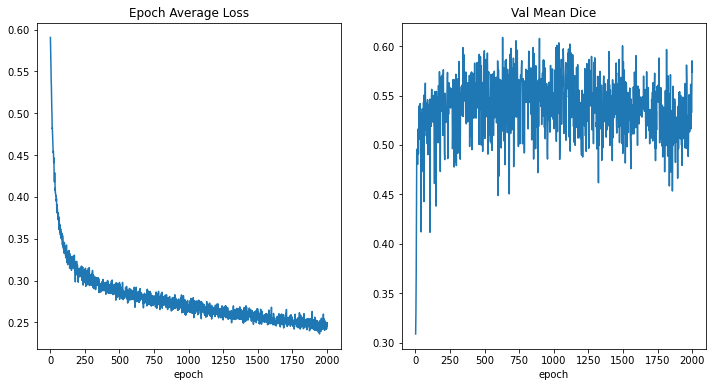

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/Image_262499828648_clean.mha


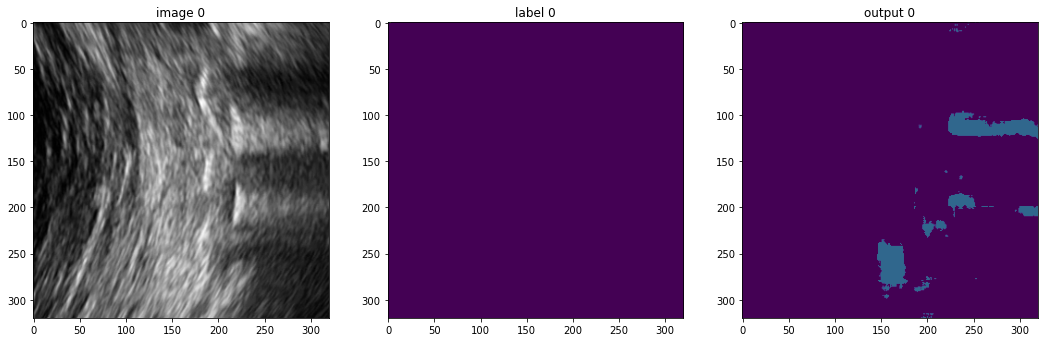

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1087766719219_clean.mha


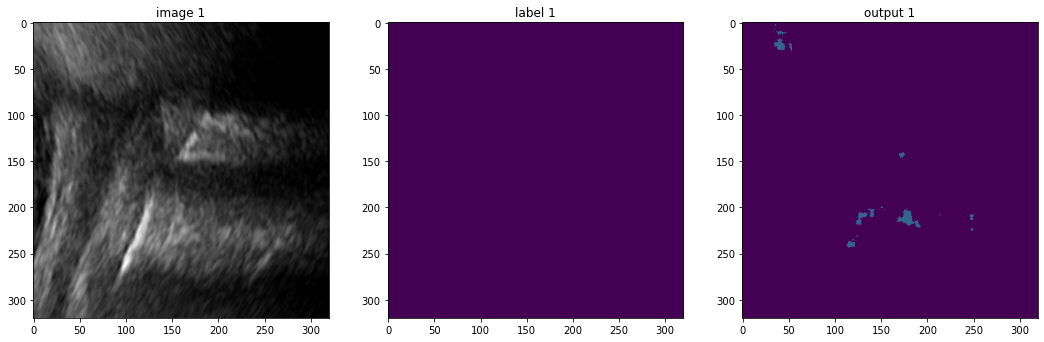

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1404802450036_clean.mha


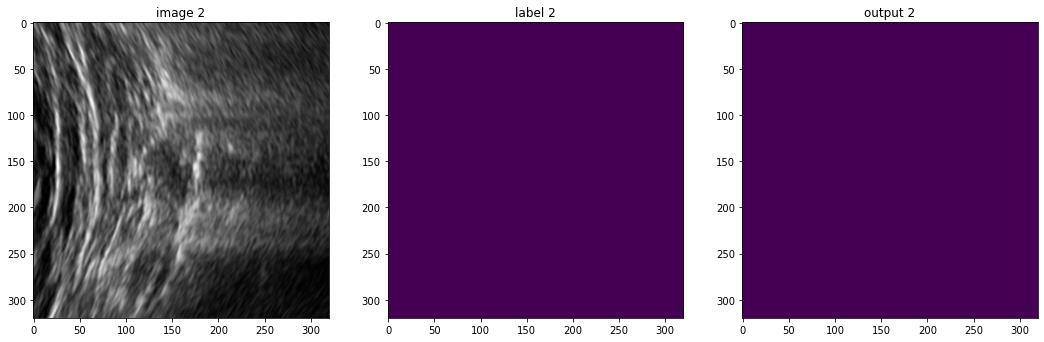

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1749559540112_clean.mha


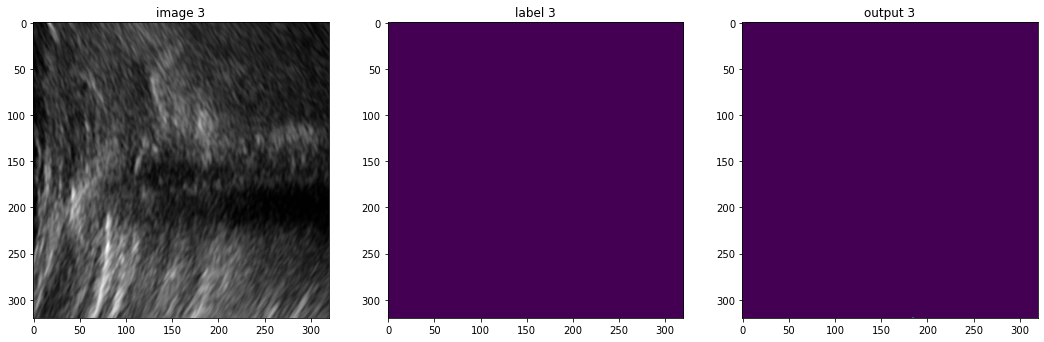

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_1895283541879_clean.mha


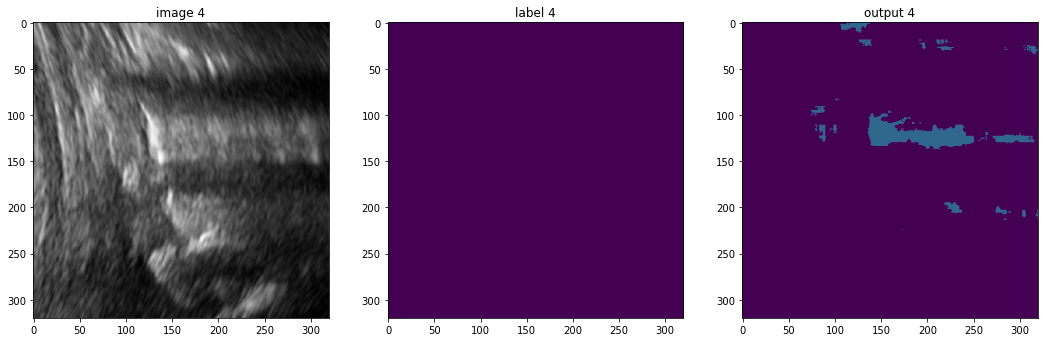

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_2454526567135_CLEAN.mha


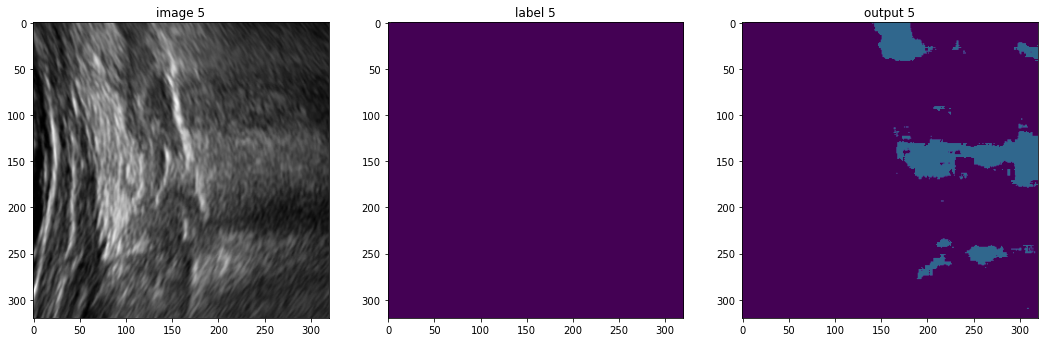

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_27180764486244_CLEAN.mha


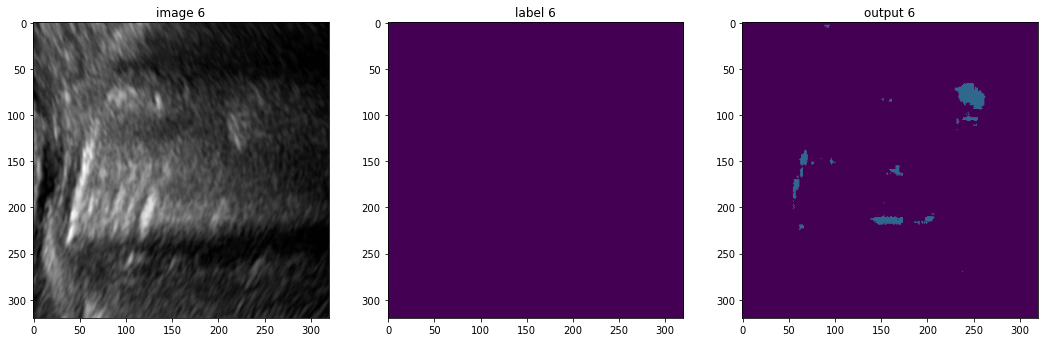

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_2734882394424_CLEAN.mha


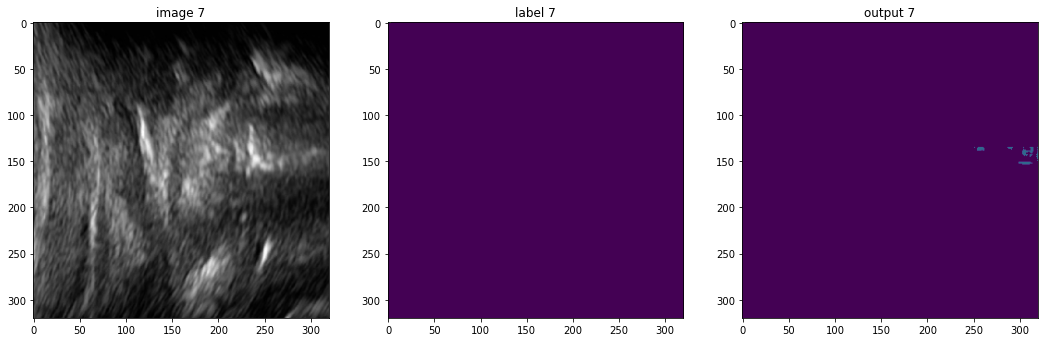

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_4641643404894_CLEAN.mha


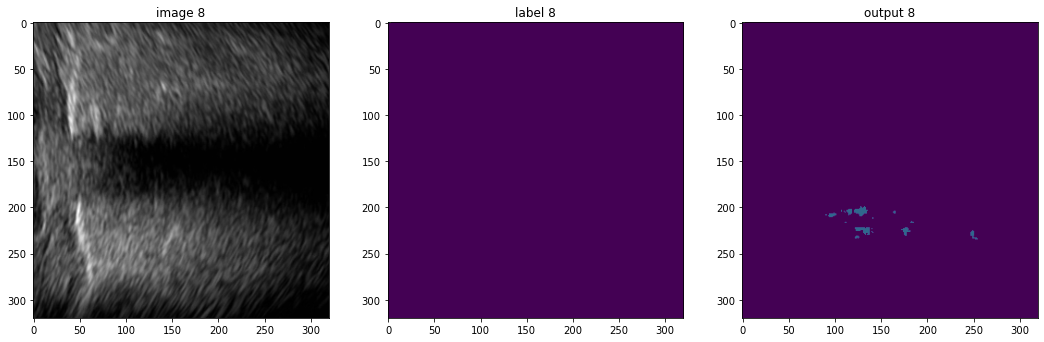

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_573611404207_CLEAN.mha


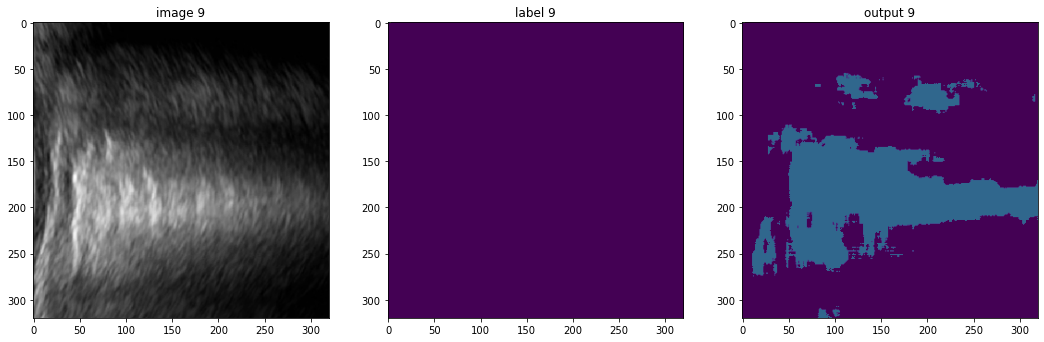

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_588695055398_clean.mha


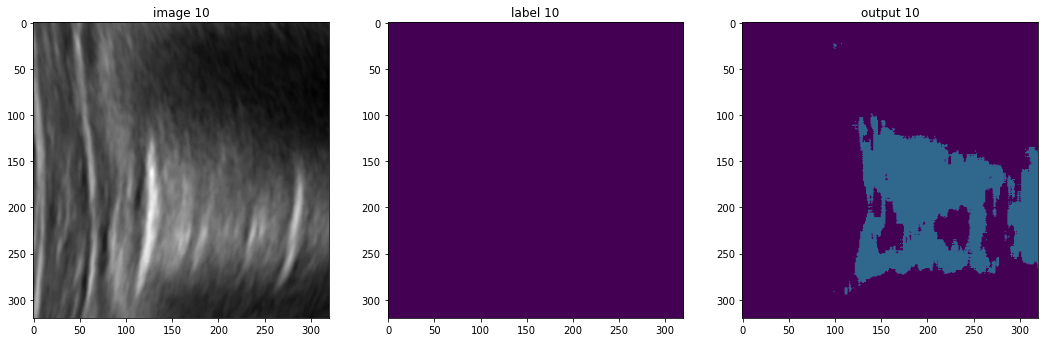

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_6056976176281_CLEAN.mha


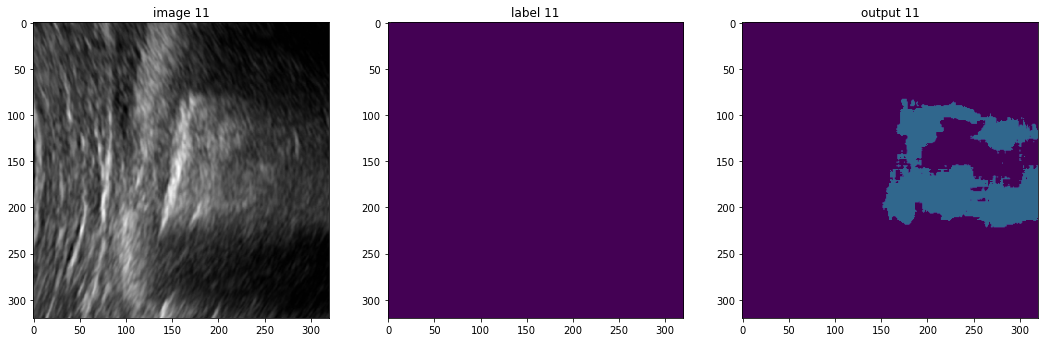

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_614587120545_clean.mha


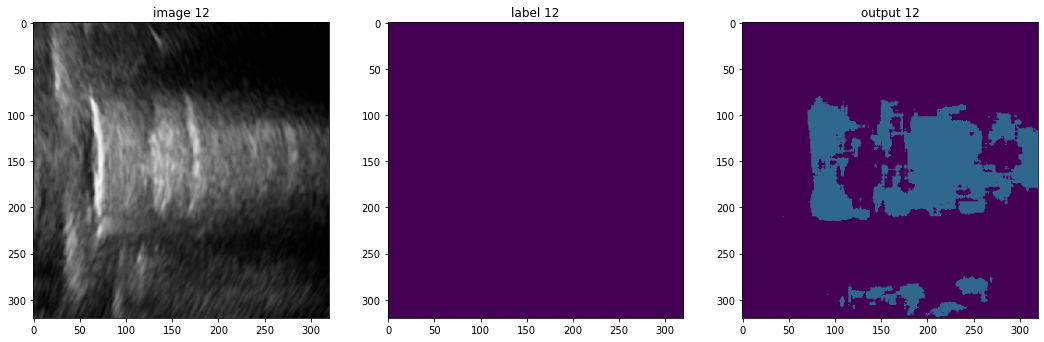

../../../Data/TrainingData/AR-UNet/BAMC-PTXNoSliding-Annotations-Linear/image_6370410622099_CLEAN.mha


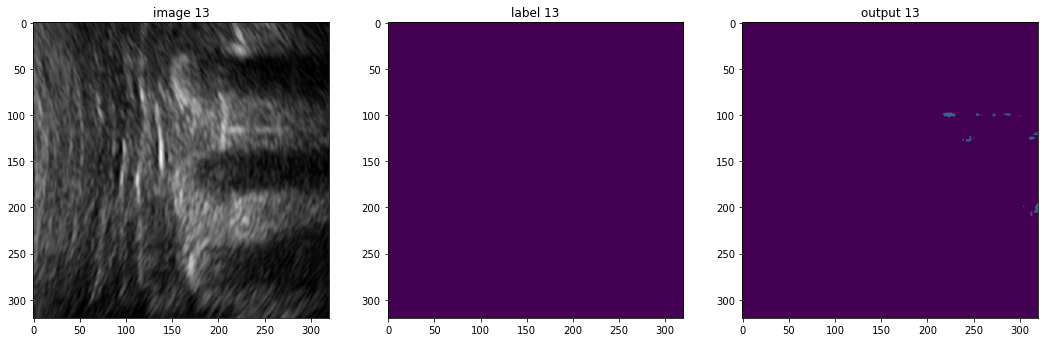

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_10391571128899_CLEAN.mha


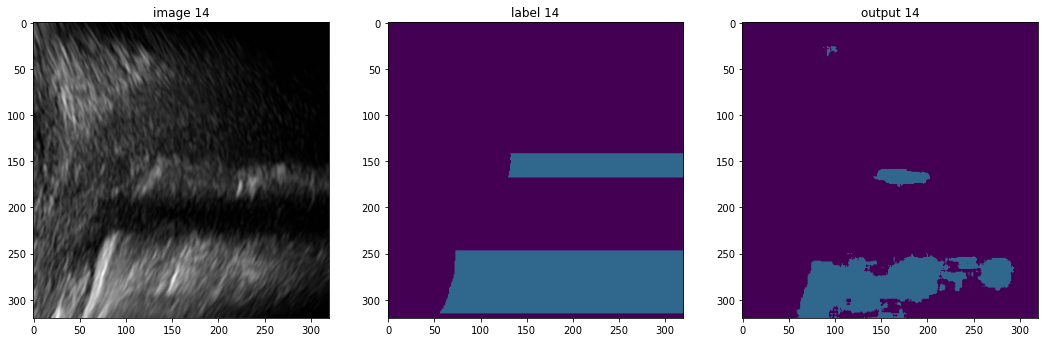

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_104932526155699_CLEAN.mha


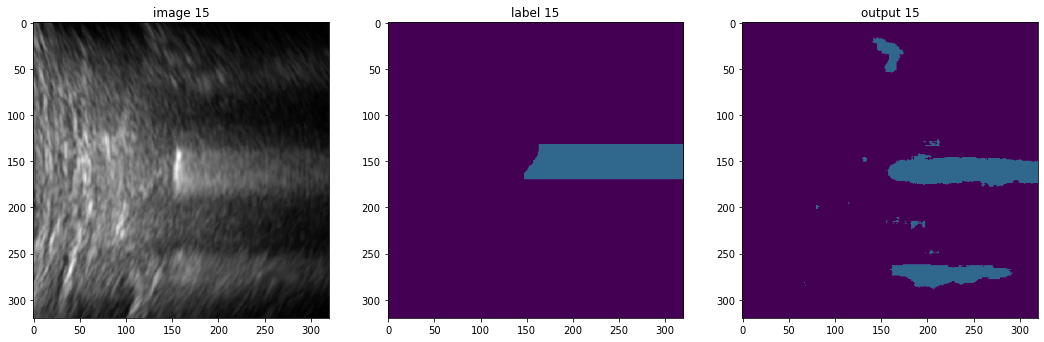

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_1327616672148_clean.mha


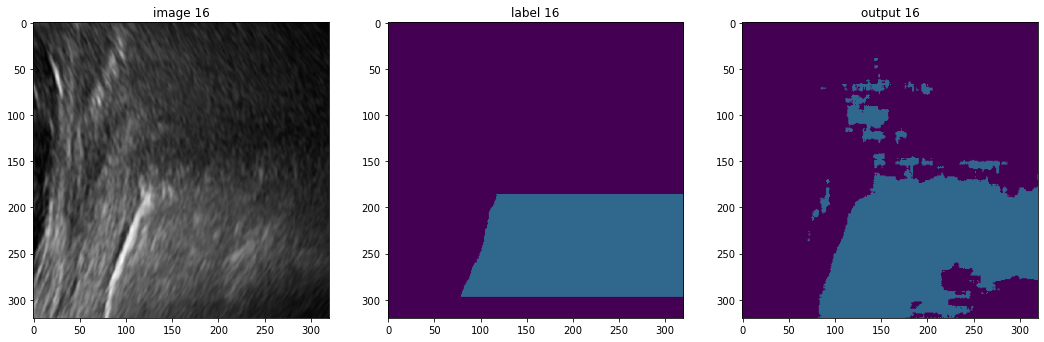

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_3315947589826_clean.mha


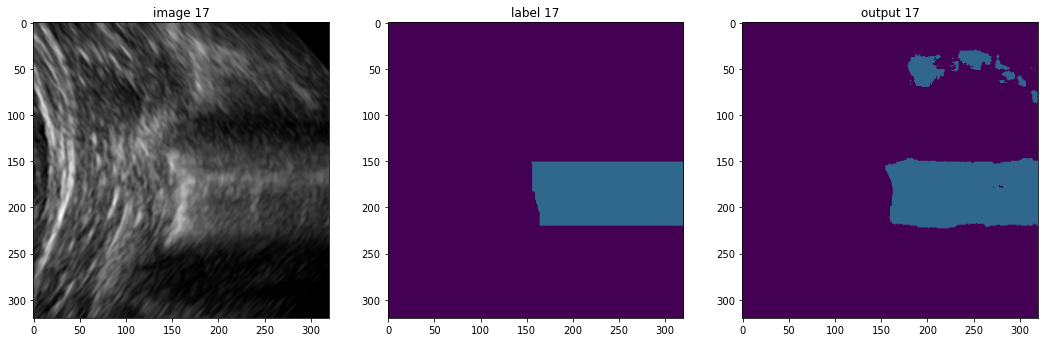

../../../Data/TrainingData/AR-UNet/BAMC-PTXSliding-Annotations-Linear/image_73815992352100_clean.mha


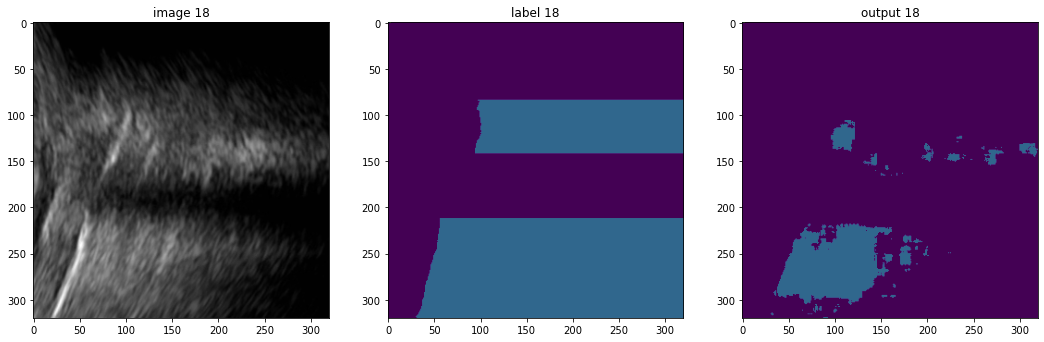

In [10]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-2Class.best_model.pth")))
model.eval()
with torch.no_grad():
    i = 0
    for b,val_data in enumerate(val_loader):
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        for j in range(val_outputs.shape[0]):
            print(val_images[i])
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            tmpV = val_data["image"][j, 0, :, :, 10]
            plt.imshow(tmpV, cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            tmpV = val_data["label"][j, 0, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            tmpV = torch.argmax(val_outputs, dim=1).detach().cpu()[j, :, :, 10]
            tmpV[0,0]=1
            tmpV[0,1]=2
            tmpV[0,2]=3
            plt.imshow(tmpV)
            plt.show()
            i += 1

## Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=True, num_classes=4),
    AsDiscreted(keys="label", to_onehot=True, num_classes=4),
])

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "BAMC_PTX_3DUNet-2Class.best_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (320, 320, 48)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)